### Import the packages

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from yahooquery import Ticker
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
sns.set()

import scipy
import statsmodels.api as sm
import sklearn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

### Importing the Data for 15 tickers

In [15]:
tc = Ticker(['aapl', 'msft', '^spx', '^N225', '^ftse', 'goog', 'amzn', 'tsla', 'meta', 'nvda', 'jpm', 'gs', 'amd', 'nflx', 'ibm'])

#### Examining the Data

In [16]:
tc_history = tc.history(start = '2018-01-01', end='2024-04-15')
df = tc_history.pivot_table(index='date', columns='symbol', values='adjclose')
df = df.reset_index(level=0)
df = df.rename(columns={'^N225': 'nikkei', '^ftse': 'ftse', '^spx': 'spx'})
df

symbol,date,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,meta,msft,nflx,nvda,tsla
0,2018-01-02,NaN,7648.100098,2695.810059,40.670975,10.980000,59.450500,53.250000,222.359329,109.547676,89.602852,181.227707,80.080910,201.070007,49.310482,21.368668
1,2018-01-03,NaN,7671.100098,2713.060059,40.663898,11.550000,60.209999,54.124001,220.289352,112.558929,89.694145,184.474274,80.453613,205.050003,52.555790,21.150000
2,2018-01-04,23506.330078,7695.899902,2723.989990,40.852768,12.120000,60.479500,54.320000,223.368134,114.838638,90.979080,184.134628,81.161697,205.630005,52.832829,20.974667
3,2018-01-05,23714.529297,7724.200195,2743.149902,41.317894,11.880000,61.457001,55.111500,222.228882,115.399681,90.395004,186.651962,82.167976,209.990005,53.280544,21.105333
4,2018-01-08,NaN,7696.500000,2747.709961,41.164429,12.280000,62.343498,55.347000,219.002228,116.095711,90.528519,188.080444,82.251823,212.050003,54.913105,22.427334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,2024-04-09,39773.128906,7934.799805,5209.910156,169.669998,170.779999,185.669998,158.139999,410.709991,189.309998,197.149994,516.900024,426.279999,618.200012,853.539978,176.880005
1631,2024-04-10,39581.808594,7961.200195,5160.640137,167.779999,167.139999,185.949997,157.660004,400.760010,186.039993,195.470001,519.830017,423.260010,618.580017,870.390015,171.759995
1632,2024-04-11,39442.628906,7923.799805,5199.060059,175.039993,170.500000,189.050003,160.789993,397.480011,185.899994,195.429993,523.159973,427.929993,628.780029,906.159973,174.600006
1633,2024-04-12,39523.550781,7995.600098,5123.410156,176.550003,163.279999,186.130005,159.190002,389.489990,182.270004,182.789993,511.899994,421.899994,622.830017,881.859985,171.050003


### Handling MIssing Values

In [17]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
df.isna().sum()

symbol
date      0
nikkei    0
ftse      0
spx       0
aapl      0
amd       0
amzn      0
goog      0
gs        0
ibm       0
jpm       0
meta      0
msft      0
nflx      0
nvda      0
tsla      0
dtype: int64

### Plotting one Ticker

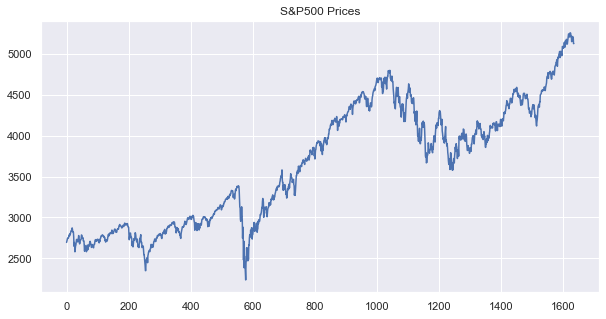

In [18]:
df.spx.plot(figsize=(10,5), title = "S&P500 Prices")
plt.show()

### From Text to Date

In [19]:
df.date.describe()

count           1635
unique          1635
top       2018-01-02
freq               1
Name: date, dtype: object

In [20]:
df.set_index("date", inplace=True)
df.head()

symbol,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,meta,msft,nflx,nvda,tsla
date,,,,,,,,,,,,,,,
2018-01-02,23506.330078,7648.100098,2695.810059,40.670975,10.98,59.450500,53.250000,222.359329,109.547676,89.602852,181.227707,80.080910,201.070007,49.310482,21.368668
2018-01-03,23506.330078,7671.100098,2713.060059,40.663898,11.55,60.209999,54.124001,220.289352,112.558929,89.694145,184.474274,80.453613,205.050003,52.555790,21.150000
2018-01-04,23506.330078,7695.899902,2723.989990,40.852768,12.12,60.479500,54.320000,223.368134,114.838638,90.979080,184.134628,81.161697,205.630005,52.832829,20.974667
2018-01-05,23714.529297,7724.200195,2743.149902,41.317894,11.88,61.457001,55.111500,222.228882,115.399681,90.395004,186.651962,82.167976,209.990005,53.280544,21.105333
2018-01-08,23714.529297,7696.500000,2747.709961,41.164429,12.28,62.343498,55.347000,219.002228,116.095711,90.528519,188.080444,82.251823,212.050003,54.913105,22.427334


In [21]:
df = df.asfreq('b')
df

symbol,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,meta,msft,nflx,nvda,tsla
date,,,,,,,,,,,,,,,
2018-01-02,23506.330078,7648.100098,2695.810059,40.670975,10.980000,59.450500,53.250000,222.359329,109.547676,89.602852,181.227707,80.080910,201.070007,49.310482,21.368668
2018-01-03,23506.330078,7671.100098,2713.060059,40.663898,11.550000,60.209999,54.124001,220.289352,112.558929,89.694145,184.474274,80.453613,205.050003,52.555790,21.150000
2018-01-04,23506.330078,7695.899902,2723.989990,40.852768,12.120000,60.479500,54.320000,223.368134,114.838638,90.979080,184.134628,81.161697,205.630005,52.832829,20.974667
2018-01-05,23714.529297,7724.200195,2743.149902,41.317894,11.880000,61.457001,55.111500,222.228882,115.399681,90.395004,186.651962,82.167976,209.990005,53.280544,21.105333
2018-01-08,23714.529297,7696.500000,2747.709961,41.164429,12.280000,62.343498,55.347000,219.002228,116.095711,90.528519,188.080444,82.251823,212.050003,54.913105,22.427334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-09,39773.128906,7934.799805,5209.910156,169.669998,170.779999,185.669998,158.139999,410.709991,189.309998,197.149994,516.900024,426.279999,618.200012,853.539978,176.880005
2024-04-10,39581.808594,7961.200195,5160.640137,167.779999,167.139999,185.949997,157.660004,400.760010,186.039993,195.470001,519.830017,423.260010,618.580017,870.390015,171.759995
2024-04-11,39442.628906,7923.799805,5199.060059,175.039993,170.500000,189.050003,160.789993,397.480011,185.899994,195.429993,523.159973,427.929993,628.780029,906.159973,174.600006


In [22]:
df = df.fillna(method = 'ffill')
df.isna().sum()

symbol
nikkei    0
ftse      0
spx       0
aapl      0
amd       0
amzn      0
goog      0
gs        0
ibm       0
jpm       0
meta      0
msft      0
nflx      0
nvda      0
tsla      0
dtype: int64

In [23]:
aapl =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta'])
nikkei =  df.drop(columns=['ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
ftse =  df.drop(columns=['nikkei','spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
spx =  df.drop(columns=['nikkei', 'ftse',  'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
amd =  df.drop(columns=['nikkei', 'ftse', 'spx','amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
amzn =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
goog =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn','gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
gs =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog','ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
ibm =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs',  'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
jpm =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm',  'msft', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
msft =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'nflx', 'nvda', 'tsla', 'meta', 'aapl'])
nflx =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nvda', 'tsla', 'meta', 'aapl'])
nvda =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx',  'tsla', 'meta', 'aapl'])
tsla =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda',  'meta', 'aapl'])
meta =  df.drop(columns=['nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'aapl'])


### LLR Test

H0: The full model and the nested model fit the data equally well. Thus, you should use the nested model.

HA: The full model fits the data significantly better than the nested model. Thus, you should use the full model.

In [24]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

 ### ACF & PACF

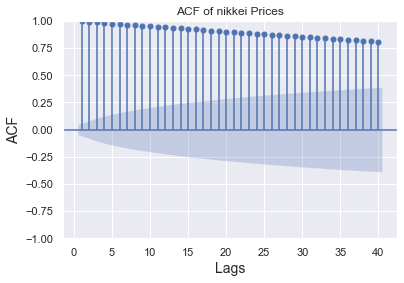

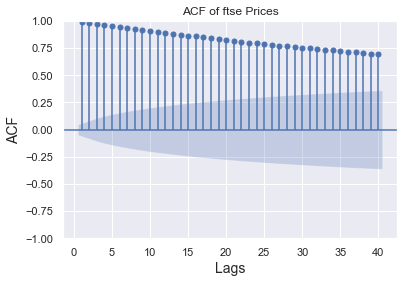

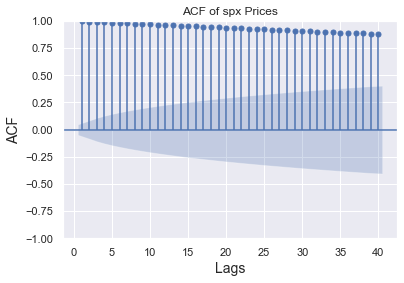

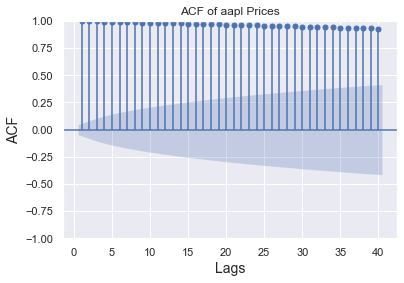

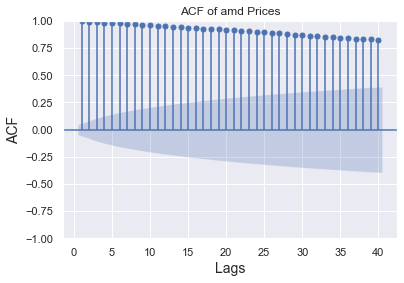

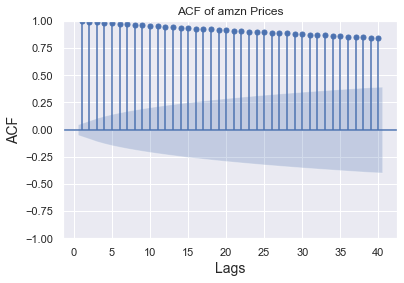

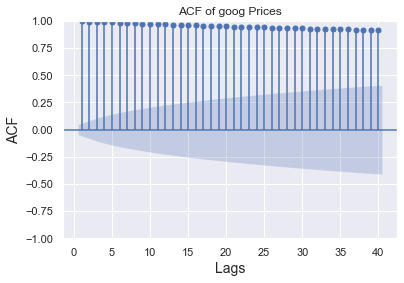

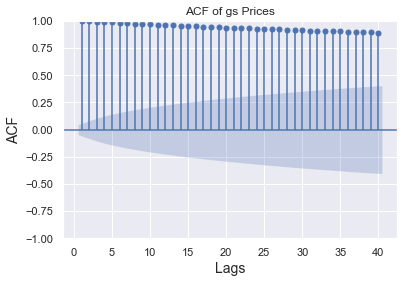

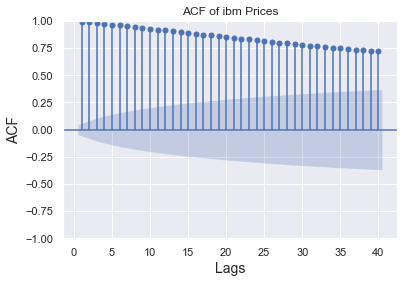

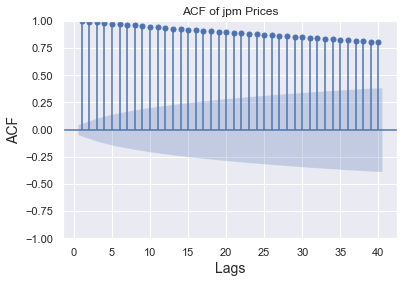

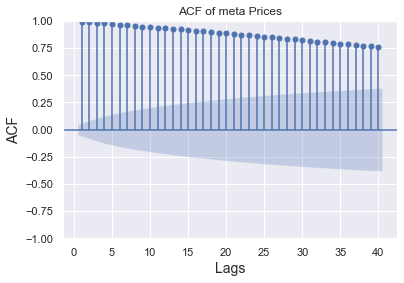

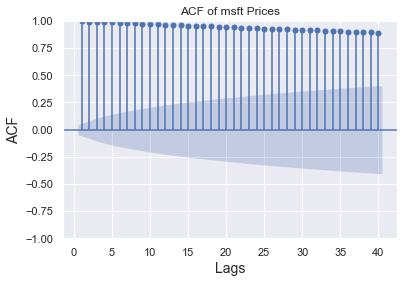

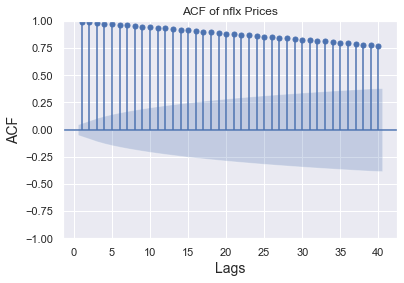

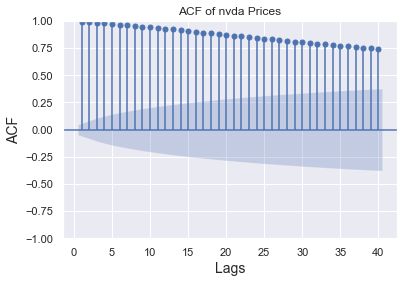

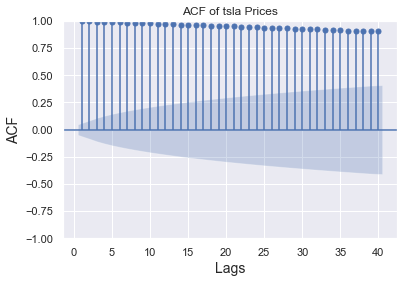

In [25]:
for ticker in df.columns:
    sgt.plot_acf(df[ticker], lags=40, zero=False)
    plt.title(f"ACF of {ticker} Prices") 
    plt.ylabel("ACF", size=14) 
    plt.xlabel("Lags", size=14) 

### Using returns

In [26]:
aapl['returns'] = aapl.aapl.pct_change(1).mul(100)
aapl = aapl.iloc[1:]

spx['returns'] = spx.spx.pct_change(1).mul(100)
spx = spx.iloc[1:]

nikkei['returns'] = nikkei.nikkei.pct_change(1).mul(100)
nikkei = nikkei.iloc[1:]

ftse['returns'] = ftse.ftse.pct_change(1).mul(100)
ftse = ftse.iloc[1:]

amd['returns'] = amd.amd.pct_change(1).mul(100)
amd = amd.iloc[1:]

amzn['returns'] = amzn.amzn.pct_change(1).mul(100)
amzn = amzn.iloc[1:]

goog['returns'] = goog.goog.pct_change(1).mul(100)
goog = goog.iloc[1:]

gs['returns'] = gs.gs.pct_change(1).mul(100)
gs = gs.iloc[1:]

ibm['returns'] = ibm.ibm.pct_change(1).mul(100)
ibm = ibm.iloc[1:]

jpm['returns'] = jpm.jpm.pct_change(1).mul(100)
jpm = jpm.iloc[1:]

msft['returns'] = msft.msft.pct_change(1).mul(100)
msft = msft.iloc[1:]

nflx['returns'] = nflx.nflx.pct_change(1).mul(100)
nflx = nflx.iloc[1:]

nvda['returns'] = nvda.nvda.pct_change(1).mul(100)
nvda = nvda.iloc[1:]

tsla['returns'] = tsla.tsla.pct_change(1).mul(100)
tsla = tsla.iloc[1:]

meta['returns'] = meta.meta.pct_change(1).mul(100)
meta = meta.iloc[1:]


### ACF and PCF for one ticker

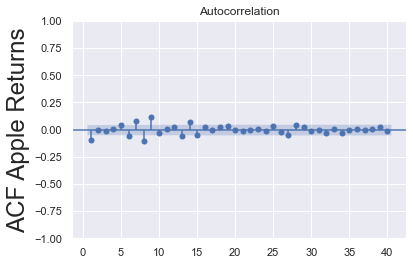

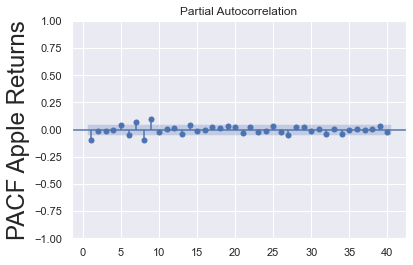

In [27]:
sgt.plot_acf(aapl.returns, lags=40, zero = False)
plt.ylabel("ACF Apple Returns", size=24)
plt.show()

sgt.plot_pacf(aapl.returns, lags=40, zero = False)
plt.ylabel("PACF Apple Returns", size=24)
plt.show()

### Dikkey Fooler

In [28]:
sts.adfuller(nikkei.returns)

(-26.786342305409963,
 0.0,
 1,
 1637,
 {'1%': -3.434350967480226,
  '5%': -2.8633071969335333,
  '10%': -2.56771081609273},
 5083.303928442854)

# AR for returns

## Aapl

In [29]:
import numpy as np
from scipy.stats import chi2
from statsmodels.tsa.arima.model import ARIMA

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

best_model_order = 1
best_model = ARIMA(aapl.returns, order=(best_model_order, 0, 0))
best_model_results = best_model.fit()

print(f"AR(1) AIC: {best_model_results.aic}, BIC: {best_model_results.bic}")


for i in range(2, 11):
    current_model = ARIMA(aapl.returns, order=(i, 0, 0))
    current_model_results = current_model.fit()
    
  
    print(f"Comparing models: AR({best_model_order}) vs AR({i})")
    p_value = LLR_test(best_model_results, current_model_results, DF=1)

    current_aic = current_model_results.aic
    current_bic = current_model_results.bic
    if current_aic < best_aic:
        best_aic = current_aic
        best_model_aic = (i, current_model_results)
    if current_bic < best_bic:
        best_bic = current_bic
        best_model_bic = (i, current_model_results)
    
   
    if p_value < 0.05:
        print(f"Model AR({i}) improves the fit, p-value = {p_value}")
        best_model_order = i
        best_model = current_model
        best_model_results = current_model_results
    else:
        print(f"Model AR({i}) does not improve the fit, p-value = {p_value}")


print(f"\nThe best model by LLR test is AR({best_model_order})")
print(best_model_results.summary())

if best_model_aic:
    print(f"The best AR model by AIC is AR({best_model_aic[0]}) with AIC: {best_aic}")
    print(best_model_aic[1].summary())

if best_model_bic:
    print(f"The best AR model by BIC is AR({best_model_bic[0]}) with BIC: {best_bic}")
    print(best_model_bic[1].summary())


AR(1) AIC: 6804.738555488317, BIC: 6820.944080224548
Comparing models: AR(1) vs AR(2)
Model AR(2) does not improve the fit, p-value = 0.667
Comparing models: AR(1) vs AR(3)
Model AR(3) does not improve the fit, p-value = 0.514
Comparing models: AR(1) vs AR(4)
Model AR(4) does not improve the fit, p-value = 0.514
Comparing models: AR(1) vs AR(5)
Model AR(5) improves the fit, p-value = 0.049
Comparing models: AR(5) vs AR(6)
Model AR(6) improves the fit, p-value = 0.04
Comparing models: AR(6) vs AR(7)
Model AR(7) improves the fit, p-value = 0.004
Comparing models: AR(7) vs AR(8)
Model AR(8) improves the fit, p-value = 0.0
Comparing models: AR(8) vs AR(9)
Model AR(9) improves the fit, p-value = 0.0
Comparing models: AR(9) vs AR(10)
Model AR(10) does not improve the fit, p-value = 0.435

The best model by LLR test is AR(9)
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1639
Model:      

## Nikkei

In [30]:
import numpy as np
from scipy.stats import chi2
from statsmodels.tsa.arima.model import ARIMA

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

best_model_order = 1
best_model = ARIMA(nikkei.returns, order=(best_model_order, 0, 0))
best_model_results = best_model.fit()

print(f"AR(1) AIC: {best_model_results.aic}, BIC: {best_model_results.bic}")


for i in range(2, 11):
    current_model = ARIMA(nikkei.returns, order=(i, 0, 0))
    current_model_results = current_model.fit()
    
  
    print(f"Comparing models: AR({best_model_order}) vs AR({i})")
    p_value = LLR_test(best_model_results, current_model_results, DF=1)

    current_aic = current_model_results.aic
    current_bic = current_model_results.bic
    if current_aic < best_aic:
        best_aic = current_aic
        best_model_aic = (i, current_model_results)
    if current_bic < best_bic:
        best_bic = current_bic
        best_model_bic = (i, current_model_results)
    
   
    if p_value < 0.05:
        print(f"Model AR({i}) improves the fit, p-value = {p_value}")
        best_model_order = i
        best_model = current_model
        best_model_results = current_model_results
    else:
        print(f"Model AR({i}) does not improve the fit, p-value = {p_value}")


print(f"\nThe best model by LLR test is AR({best_model_order})")
print(best_model_results.summary())

if best_model_aic:
    print(f"The best AR model by AIC is AR({best_model_aic[0]}) with AIC: {best_aic}")
    print(best_model_aic[1].summary())

if best_model_bic:
    print(f"The best AR model by BIC is AR({best_model_bic[0]}) with BIC: {best_bic}")
    print(best_model_bic[1].summary())


AR(1) AIC: 5176.745964117951, BIC: 5192.951488854183
Comparing models: AR(1) vs AR(2)
Model AR(2) improves the fit, p-value = 0.012
Comparing models: AR(2) vs AR(3)
Model AR(3) does not improve the fit, p-value = 0.794
Comparing models: AR(2) vs AR(4)
Model AR(4) does not improve the fit, p-value = 0.429
Comparing models: AR(2) vs AR(5)
Model AR(5) does not improve the fit, p-value = 0.288
Comparing models: AR(2) vs AR(6)
Model AR(6) does not improve the fit, p-value = 0.204
Comparing models: AR(2) vs AR(7)
Model AR(7) improves the fit, p-value = 0.004
Comparing models: AR(7) vs AR(8)
Model AR(8) does not improve the fit, p-value = 0.993
Comparing models: AR(7) vs AR(9)
Model AR(9) does not improve the fit, p-value = 0.256
Comparing models: AR(7) vs AR(10)
Model AR(10) does not improve the fit, p-value = 0.211

The best model by LLR test is AR(7)
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:     

## ftse

In [31]:
import numpy as np
from scipy.stats import chi2
from statsmodels.tsa.arima.model import ARIMA

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

best_model_order = 1
best_model = ARIMA(ftse.returns, order=(best_model_order, 0, 0))
best_model_results = best_model.fit()

print(f"AR(1) AIC: {best_model_results.aic}, BIC: {best_model_results.bic}")


for i in range(2, 11):
    current_model = ARIMA(ftse.returns, order=(i, 0, 0))
    current_model_results = current_model.fit()
    
  
    print(f"Comparing models: AR({best_model_order}) vs AR({i})")
    p_value = LLR_test(best_model_results, current_model_results, DF=1)

    current_aic = current_model_results.aic
    current_bic = current_model_results.bic
    if current_aic < best_aic:
        best_aic = current_aic
        best_model_aic = (i, current_model_results)
    if current_bic < best_bic:
        best_bic = current_bic
        best_model_bic = (i, current_model_results)
    
   
    if p_value < 0.05:
        print(f"Model AR({i}) improves the fit, p-value = {p_value}")
        best_model_order = i
        best_model = current_model
        best_model_results = current_model_results
    else:
        print(f"Model AR({i}) does not improve the fit, p-value = {p_value}")


print(f"\nThe best model by LLR test is AR({best_model_order})")
print(best_model_results.summary())

if best_model_aic:
    print(f"The best AR model by AIC is AR({best_model_aic[0]}) with AIC: {best_aic}")
    print(best_model_aic[1].summary())

if best_model_bic:
    print(f"The best AR model by BIC is AR({best_model_bic[0]}) with BIC: {best_bic}")
    print(best_model_bic[1].summary())


AR(1) AIC: 4759.575895683885, BIC: 4775.781420420117
Comparing models: AR(1) vs AR(2)
Model AR(2) does not improve the fit, p-value = 0.641
Comparing models: AR(1) vs AR(3)
Model AR(3) does not improve the fit, p-value = 0.268
Comparing models: AR(1) vs AR(4)
Model AR(4) does not improve the fit, p-value = 0.178
Comparing models: AR(1) vs AR(5)
Model AR(5) improves the fit, p-value = 0.011
Comparing models: AR(5) vs AR(6)
Model AR(6) improves the fit, p-value = 0.0
Comparing models: AR(6) vs AR(7)
Model AR(7) improves the fit, p-value = 0.0
Comparing models: AR(7) vs AR(8)
Model AR(8) improves the fit, p-value = 0.038
Comparing models: AR(8) vs AR(9)
Model AR(9) does not improve the fit, p-value = 0.243
Comparing models: AR(8) vs AR(10)
Model AR(10) does not improve the fit, p-value = 0.204

The best model by LLR test is AR(8)
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1639
Mod

## spx

In [32]:
import numpy as np
from scipy.stats import chi2
from statsmodels.tsa.arima.model import ARIMA

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

best_model_order = 1
best_model = ARIMA(spx.returns, order=(best_model_order, 0, 0))
best_model_results = best_model.fit()

print(f"AR(1) AIC: {best_model_results.aic}, BIC: {best_model_results.bic}")


for i in range(2, 11):
    current_model = ARIMA(spx.returns, order=(i, 0, 0))
    current_model_results = current_model.fit()
    
  
    print(f"Comparing models: AR({best_model_order}) vs AR({i})")
    p_value = LLR_test(best_model_results, current_model_results, DF=1)

    current_aic = current_model_results.aic
    current_bic = current_model_results.bic
    if current_aic < best_aic:
        best_aic = current_aic
        best_model_aic = (i, current_model_results)
    if current_bic < best_bic:
        best_bic = current_bic
        best_model_bic = (i, current_model_results)
    
   
    if p_value < 0.05:
        print(f"Model AR({i}) improves the fit, p-value = {p_value}")
        best_model_order = i
        best_model = current_model
        best_model_results = current_model_results
    else:
        print(f"Model AR({i}) does not improve the fit, p-value = {p_value}")


print(f"\nThe best model by LLR test is AR({best_model_order})")
print(best_model_results.summary())

if best_model_aic:
    print(f"The best AR model by AIC is AR({best_model_aic[0]}) with AIC: {best_aic}")
    print(best_model_aic[1].summary())

if best_model_bic:
    print(f"The best AR model by BIC is AR({best_model_bic[0]}) with BIC: {best_bic}")
    print(best_model_bic[1].summary())


AR(1) AIC: 5365.008757522599, BIC: 5381.21428225883
Comparing models: AR(1) vs AR(2)
Model AR(2) improves the fit, p-value = 0.004
Comparing models: AR(2) vs AR(3)
Model AR(3) does not improve the fit, p-value = 0.89
Comparing models: AR(2) vs AR(4)
Model AR(4) improves the fit, p-value = 0.028
Comparing models: AR(4) vs AR(5)
Model AR(5) does not improve the fit, p-value = 0.177
Comparing models: AR(4) vs AR(6)
Model AR(6) improves the fit, p-value = 0.0
Comparing models: AR(6) vs AR(7)
Model AR(7) improves the fit, p-value = 0.0
Comparing models: AR(7) vs AR(8)
Model AR(8) improves the fit, p-value = 0.001
Comparing models: AR(8) vs AR(9)
Model AR(9) improves the fit, p-value = 0.0
Comparing models: AR(9) vs AR(10)
Model AR(10) does not improve the fit, p-value = 0.106

The best model by LLR test is AR(9)
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1639
Model:                 

In [33]:
from statsmodels.tsa.arima.model import ARIMA

model_ar_6 = ARIMA(spx.returns, order=(6, 0, 0))
results_ar_6 = model_ar_6.fit()

aic_ar_6 = results_ar_6.aic
print(f"The AIC for the AR(6) model is: {aic_ar_6:.2f}")


The AIC for the AR(6) model is: 5334.50


## amd

In [34]:
import numpy as np
from scipy.stats import chi2
from statsmodels.tsa.arima.model import ARIMA

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

best_model_order = 1
best_model = ARIMA(amd.returns, order=(best_model_order, 0, 0))
best_model_results = best_model.fit()

print(f"AR(1) AIC: {best_model_results.aic}, BIC: {best_model_results.bic}")


for i in range(2, 11):
    current_model = ARIMA(amd.returns, order=(i, 0, 0))
    current_model_results = current_model.fit()
    
  
    print(f"Comparing models: AR({best_model_order}) vs AR({i})")
    p_value = LLR_test(best_model_results, current_model_results, DF=1)

    current_aic = current_model_results.aic
    current_bic = current_model_results.bic
    if current_aic < best_aic:
        best_aic = current_aic
        best_model_aic = (i, current_model_results)
    if current_bic < best_bic:
        best_bic = current_bic
        best_model_bic = (i, current_model_results)
    
   
    if p_value < 0.05:
        print(f"Model AR({i}) improves the fit, p-value = {p_value}")
        best_model_order = i
        best_model = current_model
        best_model_results = current_model_results
    else:
        print(f"Model AR({i}) does not improve the fit, p-value = {p_value}")


print(f"\nThe best model by LLR test is AR({best_model_order})")
print(best_model_results.summary())

if best_model_aic:
    print(f"The best AR model by AIC is AR({best_model_aic[0]}) with AIC: {best_aic}")
    print(best_model_aic[1].summary())

if best_model_bic:
    print(f"The best AR model by BIC is AR({best_model_bic[0]}) with BIC: {best_bic}")
    print(best_model_bic[1].summary())


AR(1) AIC: 8676.9654398041, BIC: 8693.170964540332
Comparing models: AR(1) vs AR(2)
Model AR(2) does not improve the fit, p-value = 0.356
Comparing models: AR(1) vs AR(3)
Model AR(3) improves the fit, p-value = 0.044
Comparing models: AR(3) vs AR(4)
Model AR(4) does not improve the fit, p-value = 0.956
Comparing models: AR(3) vs AR(5)
Model AR(5) does not improve the fit, p-value = 0.524
Comparing models: AR(3) vs AR(6)
Model AR(6) does not improve the fit, p-value = 0.218
Comparing models: AR(3) vs AR(7)
Model AR(7) improves the fit, p-value = 0.037
Comparing models: AR(7) vs AR(8)
Model AR(8) does not improve the fit, p-value = 0.584
Comparing models: AR(7) vs AR(9)
Model AR(9) does not improve the fit, p-value = 0.145
Comparing models: AR(7) vs AR(10)
Model AR(10) does not improve the fit, p-value = 0.071

The best model by LLR test is AR(7)
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:       

## amzn

In [35]:
import numpy as np
from scipy.stats import chi2
from statsmodels.tsa.arima.model import ARIMA

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

best_model_order = 1
best_model = ARIMA(amd.returns, order=(best_model_order, 0, 0))
best_model_results = best_model.fit()

print(f"AR(1) AIC: {best_model_results.aic}, BIC: {best_model_results.bic}")


for i in range(2, 11):
    current_model = ARIMA(amzn.returns, order=(i, 0, 0))
    current_model_results = current_model.fit()
    
  
    print(f"Comparing models: AR({best_model_order}) vs AR({i})")
    p_value = LLR_test(best_model_results, current_model_results, DF=1)

    current_aic = current_model_results.aic
    current_bic = current_model_results.bic
    if current_aic < best_aic:
        best_aic = current_aic
        best_model_aic = (i, current_model_results)
    if current_bic < best_bic:
        best_bic = current_bic
        best_model_bic = (i, current_model_results)
    
   
    if p_value < 0.05:
        print(f"Model AR({i}) improves the fit, p-value = {p_value}")
        best_model_order = i
        best_model = current_model
        best_model_results = current_model_results
    else:
        print(f"Model AR({i}) does not improve the fit, p-value = {p_value}")


print(f"\nThe best model by LLR test is AR({best_model_order})")
print(best_model_results.summary())

if best_model_aic:
    print(f"The best AR model by AIC is AR({best_model_aic[0]}) with AIC: {best_aic}")
    print(best_model_aic[1].summary())

if best_model_bic:
    print(f"The best AR model by BIC is AR({best_model_bic[0]}) with BIC: {best_bic}")
    print(best_model_bic[1].summary())


AR(1) AIC: 7183.876398170534, BIC: 7200.081922906766
Comparing models: AR(1) vs AR(2)
Model AR(2) does not improve the fit, p-value = 0.965
Comparing models: AR(1) vs AR(3)
Model AR(3) does not improve the fit, p-value = 0.385
Comparing models: AR(1) vs AR(4)
Model AR(4) does not improve the fit, p-value = 0.083
Comparing models: AR(1) vs AR(5)
Model AR(5) does not improve the fit, p-value = 0.083
Comparing models: AR(1) vs AR(6)
Model AR(6) does not improve the fit, p-value = 0.071
Comparing models: AR(1) vs AR(7)
Model AR(7) does not improve the fit, p-value = 0.059
Comparing models: AR(1) vs AR(8)
Model AR(8) improves the fit, p-value = 0.002
Comparing models: AR(8) vs AR(9)
Model AR(9) does not improve the fit, p-value = 0.174
Comparing models: AR(8) vs AR(10)
Model AR(10) does not improve the fit, p-value = 0.059

The best model by LLR test is AR(8)
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observatio

## goog

In [36]:
import numpy as np
from scipy.stats import chi2
from statsmodels.tsa.arima.model import ARIMA

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

best_model_order = 1
best_model = ARIMA(goog.returns, order=(best_model_order, 0, 0))
best_model_results = best_model.fit()

print(f"AR(1) AIC: {best_model_results.aic}, BIC: {best_model_results.bic}")


for i in range(2, 11):
    current_model = ARIMA(goog.returns, order=(i, 0, 0))
    current_model_results = current_model.fit()
    
  
    print(f"Comparing models: AR({best_model_order}) vs AR({i})")
    p_value = LLR_test(best_model_results, current_model_results, DF=1)

    current_aic = current_model_results.aic
    current_bic = current_model_results.bic
    if current_aic < best_aic:
        best_aic = current_aic
        best_model_aic = (i, current_model_results)
    if current_bic < best_bic:
        best_bic = current_bic
        best_model_bic = (i, current_model_results)
    
   
    if p_value < 0.05:
        print(f"Model AR({i}) improves the fit, p-value = {p_value}")
        best_model_order = i
        best_model = current_model
        best_model_results = current_model_results
    else:
        print(f"Model AR({i}) does not improve the fit, p-value = {p_value}")


print(f"\nThe best model by LLR test is AR({best_model_order})")
print(best_model_results.summary())

if best_model_aic:
    print(f"The best AR model by AIC is AR({best_model_aic[0]}) with AIC: {best_aic}")
    print(best_model_aic[1].summary())

if best_model_bic:
    print(f"The best AR model by BIC is AR({best_model_bic[0]}) with BIC: {best_bic}")
    print(best_model_bic[1].summary())


AR(1) AIC: 6783.9598829726765, BIC: 6800.165407708908
Comparing models: AR(1) vs AR(2)
Model AR(2) does not improve the fit, p-value = 0.656
Comparing models: AR(1) vs AR(3)
Model AR(3) does not improve the fit, p-value = 0.353
Comparing models: AR(1) vs AR(4)
Model AR(4) does not improve the fit, p-value = 0.304
Comparing models: AR(1) vs AR(5)
Model AR(5) does not improve the fit, p-value = 0.198
Comparing models: AR(1) vs AR(6)
Model AR(6) improves the fit, p-value = 0.001
Comparing models: AR(6) vs AR(7)
Model AR(7) does not improve the fit, p-value = 0.148
Comparing models: AR(6) vs AR(8)
Model AR(8) improves the fit, p-value = 0.006
Comparing models: AR(8) vs AR(9)
Model AR(9) improves the fit, p-value = 0.0
Comparing models: AR(9) vs AR(10)
Model AR(10) does not improve the fit, p-value = 0.596

The best model by LLR test is AR(9)
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:              

In [37]:
from statsmodels.tsa.arima.model import ARIMA


model_ar_6 = ARIMA(goog.returns, order=(6, 0, 0))
results_ar_6 = model_ar_6.fit()

aic_ar_6 = results_ar_6.aic
print(f"The AIC for the AR(6) model is: {aic_ar_6:.2f}")


The AIC for the AR(6) model is: 6782.45


### Normalized Returns

In [38]:
benchmark = aapl.aapl.iloc[0]

In [39]:
aapl['norm'] = aapl.aapl.div(benchmark).mul(100)

In [40]:
sts.adfuller(aapl.norm)

(-0.8706535422904793,
 0.7974829725032808,
 10,
 1628,
 {'1%': -3.4343731208729635,
  '5%': -2.8633169753343646,
  '10%': -2.5677160229913856},
 9972.748589227458)

In [41]:
bench_ret = aapl.returns.iloc[0]
aapl['norm_ret'] = aapl.returns.div(bench_ret).mul(100)
sts.adfuller(aapl.norm_ret)

(-12.765820103477232,
 7.962126970978965e-24,
 8,
 1630,
 {'1%': -3.4343681767217062,
  '5%': -2.863314793016078,
  '10%': -2.5677148609281493},
 34598.94370840102)

## Normalized Returns

In [42]:
aapl

symbol,aapl,returns,norm,norm_ret
date,,,,
2018-01-03,40.663898,-0.017399,100.000000,100.000000
2018-01-04,40.852768,0.464465,100.464465,-2669.521069
2018-01-05,41.317894,1.138542,101.608295,-6543.796026
2018-01-08,41.164429,-0.371426,101.230896,2134.777037
2018-01-09,41.159706,-0.011473,101.219282,65.938524
...,...,...,...,...
2024-04-09,169.669998,0.724251,417.249709,-4162.649523
2024-04-10,167.779999,-1.113927,412.601853,6402.317354
2024-04-11,175.039993,4.327092,430.455514,-24870.052047


In [43]:
model_norm_ret_ar_1 = ARIMA (aapl.norm_ret, order=(1,0, 0))
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()
results_norm_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 1639
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -17587.412
Date:                Tue, 30 Apr 2024   AIC                          35180.824
Time:                        22:53:53   BIC                          35197.030
Sample:                    01-03-2018   HQIC                         35186.835
                         - 04-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -622.6853    249.852     -2.492      0.013   -1112.386    -132.985
ar.L1         -0.0982      0.015     -6.668      0.000      -0.127      -0.069
sigma2      1.225e+08      0.001   9.49e+10      0.000    1.23e+08    1.23e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1517.55
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.06
Prob(H) (two-sided):                  0.73   Kurtosis:                         7.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.57e+25. Standard errors may be unstable.
"""

In [44]:
model_norm_ret_ar_9 = ARIMA (aapl.norm_ret, order=(9,0, 0))
results_norm_ret_ar_9 = model_norm_ret_ar_9.fit()
results_norm_ret_ar_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 1639
Model:                 ARIMA(9, 0, 0)   Log Likelihood              -17563.940
Date:                Tue, 30 Apr 2024   AIC                          35149.880
Time:                        22:53:54   BIC                          35209.300
Sample:                    01-03-2018   HQIC                         35171.918
                         - 04-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -622.6853    276.649     -2.251      0.024   -1164.907     -80.463
ar.L1         -0.0774      0.018     -4.197      0.000      -0.114      -0.041
ar.L2         -0.0243      0.019     -1.297      0.195      -0.061       0.012
ar.L3         -0.0040      0.019     -0.210      0.834      -0.041       0.033
ar.L4          0.0013      0.019      0.065      0.948      -0.037       0.039
ar.L5          0.0401      0.019      2.165      0.030       0.004       0.076
ar.L6         -0.0442      0.017     -2.622      0.009      -0.077      -0.011
ar.L7          0.0649      0.020      3.172      0.002       0.025       0.105
ar.L8         -0.0845      0.019     -4.475      0.000      -0.121      -0.047
ar.L9          0.0990      0.019      5.309      0.000       0.062       0.136
sigma2      1.196e+08      0.003   4.25e+10      0.000     1.2e+08     1.2e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               945.29
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.11
Prob(H) (two-sided):                  0.67   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.37e+25. Standard errors may be unstable.
"""

In [45]:
model_ret_ar_9 = ARIMA(aapl.returns, order = (9,0,0))
results_ret_ar_9 = model_ret_ar_9.fit()
print(results_ret_ar_9.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1639
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -3375.887
Date:                Tue, 30 Apr 2024   AIC                           6773.773
Time:                        22:53:55   BIC                           6833.194
Sample:                    01-03-2018   HQIC                          6795.811
                         - 04-15-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1085      0.048      2.254      0.024       0.014       0.203
ar.L1         -0.0774      0.019     -4.161      0.000      -0.114      -0.041
ar.L2         -0.0243      0.019     -1.303      0.1

In [46]:
aapl['res_ret'] = results_ret_ar_9.resid

In [47]:
aapl.res_ret.mean()

1.6423168340981185e-05

In [48]:
aapl.res_ret.var()

3.6040194286113945

In [49]:
sts.adfuller(aapl.res_ret)

(-40.3723854998921,
 0.0,
 0,
 1638,
 {'1%': -3.4343485210432236,
  '5%': -2.863306117083598,
  '10%': -2.5677102410843804},
 6657.038686191614)

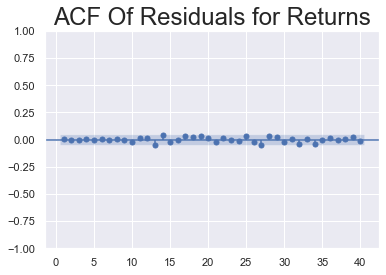

In [50]:
sgt.plot_acf(aapl.res_ret, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

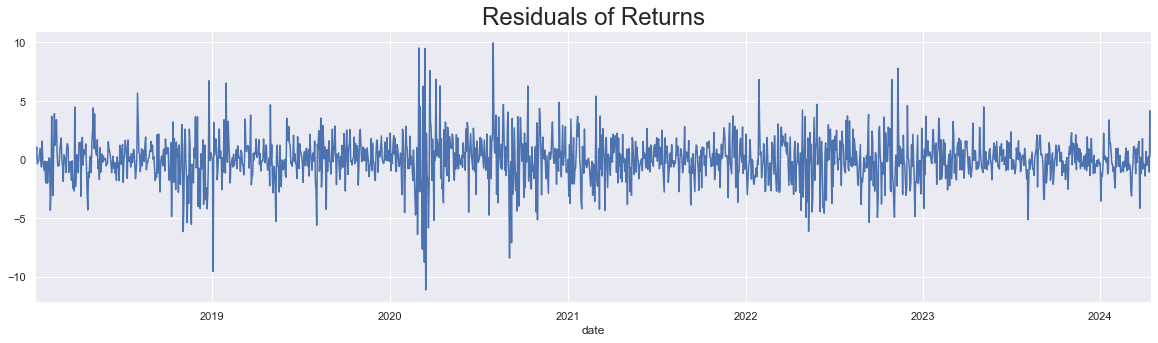

In [51]:
aapl.res_ret.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

# MA for all tickers

## aapl

In [52]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2

def LLR_test(model1, model2, DF=1):
    L1 = model1.fit().llf
    L2 = model2.fit().llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_MA_order = 1
best_MA_model = ARIMA(aapl.returns, order=(0, 0, best_MA_order))
best_MA_results = best_MA_model.fit()

for i in range(2, 11):
    current_MA_model = ARIMA(aapl.returns, order=(0, 0, i))
    current_MA_results = current_MA_model.fit()
    
    print(f"Comparing models: MA({best_MA_order}) vs MA({i})")
    p_value = LLR_test(best_MA_model, current_MA_model)
    
    if p_value < 0.05:
        print(f"Model MA({i}) improves the fit, p-value = {p_value}")
        best_MA_order = i
        best_MA_model = current_MA_model
        best_MA_results = current_MA_results
    else:
        print(f"Model MA({i}) does not improve the fit, p-value = {p_value}")



print(f"The best model is MA({best_MA_order})")
print(best_MA_results.summary())

Comparing models: MA(1) vs MA(2)
Model MA(2) does not improve the fit, p-value = 0.909403037363114
Comparing models: MA(1) vs MA(3)
Model MA(3) does not improve the fit, p-value = 0.6851454684877031
Comparing models: MA(1) vs MA(4)
Model MA(4) does not improve the fit, p-value = 0.5234213245176343
Comparing models: MA(1) vs MA(5)
Model MA(5) does not improve the fit, p-value = 0.11867747938985582
Comparing models: MA(1) vs MA(6)
Model MA(6) improves the fit, p-value = 0.011042005375394159
Comparing models: MA(6) vs MA(7)
Model MA(7) improves the fit, p-value = 0.013719931673552333
Comparing models: MA(7) vs MA(8)
Model MA(8) improves the fit, p-value = 0.002347036611380286
Comparing models: MA(8) vs MA(9)
Model MA(9) improves the fit, p-value = 2.1626765055609853e-05
Comparing models: MA(9) vs MA(10)
Model MA(10) does not improve the fit, p-value = 0.15236023553081904
The best model is MA(9)
                               SARIMAX Results                                
Dep. Variable:  

## nikkei

In [53]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2

def LLR_test(model1, model2, DF=1):
    L1 = model1.fit().llf
    L2 = model2.fit().llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_MA_order = 1
best_MA_model = ARIMA(nikkei.returns, order=(0, 0, best_MA_order))
best_MA_results = best_MA_model.fit()

for i in range(2, 11):
    current_MA_model = ARIMA(nikkei.returns, order=(0, 0, i))
    current_MA_results = current_MA_model.fit()
    
    print(f"Comparing models: MA({best_MA_order}) vs MA({i})")
    p_value = LLR_test(best_MA_model, current_MA_model)
    
    if p_value < 0.05:
        print(f"Model MA({i}) improves the fit, p-value = {p_value}")
        best_MA_order = i
        best_MA_model = current_MA_model
        best_MA_results = current_MA_results
    else:
        print(f"Model MA({i}) does not improve the fit, p-value = {p_value}")



print(f"The best model is MA({best_MA_order})")
print(best_MA_results.summary())

Comparing models: MA(1) vs MA(2)
Model MA(2) improves the fit, p-value = 0.01061578049970345
Comparing models: MA(2) vs MA(3)
Model MA(3) does not improve the fit, p-value = 0.7268948176483575
Comparing models: MA(2) vs MA(4)
Model MA(4) does not improve the fit, p-value = 0.5720409832913249
Comparing models: MA(2) vs MA(5)
Model MA(5) does not improve the fit, p-value = 0.5179652575116791
Comparing models: MA(2) vs MA(6)
Model MA(6) does not improve the fit, p-value = 0.306391716365152
Comparing models: MA(2) vs MA(7)
Model MA(7) improves the fit, p-value = 0.003702500294358994
Comparing models: MA(7) vs MA(8)
Model MA(8) does not improve the fit, p-value = 0.9946529700566646
Comparing models: MA(7) vs MA(9)
Model MA(9) does not improve the fit, p-value = 0.5418146554725635
Comparing models: MA(7) vs MA(10)
Model MA(10) does not improve the fit, p-value = 0.4731569329083639
The best model is MA(7)
                               SARIMAX Results                                
Dep. Vari

## ftse

In [54]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2

def LLR_test(model1, model2, DF=1):
    L1 = model1.fit().llf
    L2 = model2.fit().llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_MA_order = 1
best_MA_model = ARIMA(ftse.returns, order=(0, 0, best_MA_order))
best_MA_results = best_MA_model.fit()

for i in range(2, 11):
    current_MA_model = ARIMA(ftse.returns, order=(0, 0, i))
    current_MA_results = current_MA_model.fit()
    
    print(f"Comparing models: MA({best_MA_order}) vs MA({i})")
    p_value = LLR_test(best_MA_model, current_MA_model)
    
    if p_value < 0.05:
        print(f"Model MA({i}) improves the fit, p-value = {p_value}")
        best_MA_order = i
        best_MA_model = current_MA_model
        best_MA_results = current_MA_results
    else:
        print(f"Model MA({i}) does not improve the fit, p-value = {p_value}")



print(f"The best model is MA({best_MA_order})")
print(best_MA_results.summary())

Comparing models: MA(1) vs MA(2)
Model MA(2) does not improve the fit, p-value = 0.6651280521635043
Comparing models: MA(1) vs MA(3)
Model MA(3) does not improve the fit, p-value = 0.22175164224038355
Comparing models: MA(1) vs MA(4)
Model MA(4) does not improve the fit, p-value = 0.06050890660443338
Comparing models: MA(1) vs MA(5)
Model MA(5) improves the fit, p-value = 0.016612889825506377
Comparing models: MA(5) vs MA(6)
Model MA(6) improves the fit, p-value = 1.864889374386134e-05
Comparing models: MA(6) vs MA(7)
Model MA(7) improves the fit, p-value = 0.001274326123642846
Comparing models: MA(7) vs MA(8)
Model MA(8) does not improve the fit, p-value = 0.08110021012172645
Comparing models: MA(7) vs MA(9)
Model MA(9) improves the fit, p-value = 0.01297156106570496
Comparing models: MA(9) vs MA(10)
Model MA(10) does not improve the fit, p-value = 0.7103948804187461
The best model is MA(9)
                               SARIMAX Results                                
Dep. Variable:  

## spx

In [92]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2

def LLR_test(model1, model2, DF=1):
    L1 = model1.llf
    L2 = model2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_MA_model = ARIMA(spx.returns, order=(0, 0, 1))
best_MA_results = best_MA_model.fit()

for i in range(2, 11):
    current_MA_model = ARIMA(spx.returns, order=(0, 0, i))
    current_MA_results = current_MA_model.fit()
    
    print(f"Comparing models: MA(1) vs MA({i})")
    p_value = LLR_test(best_MA_results, current_MA_results)
    
    if p_value < 0.05 and (current_MA_results.aic < best_MA_results.aic or current_MA_results.bic < best_MA_results.bic):
        print(f"Model MA({i}) improves the fit, p-value = {p_value}, AIC = {current_MA_results.aic}, BIC = {current_MA_results.bic}")
        best_MA_order = i
        best_MA_results = current_MA_results
    else:
        print(f"Model MA({i}) does not improve the fit, p-value = {p_value}")

print(f"The best model is MA({best_MA_order})")
print(best_MA_results.summary())


Comparing models: MA(1) vs MA(2)
Model MA(2) improves the fit, p-value = 0.00017361600341718415, AIC = 5359.038815926955, BIC = 5380.646182241931
Comparing models: MA(1) vs MA(3)
Model MA(3) does not improve the fit, p-value = 0.16081937094924542
Comparing models: MA(1) vs MA(4)
Model MA(4) does not improve the fit, p-value = 0.1129300246247202
Comparing models: MA(1) vs MA(5)
Model MA(5) does not improve the fit, p-value = 0.1089451400538989
Comparing models: MA(1) vs MA(6)
Model MA(6) improves the fit, p-value = 6.533867447911837e-06, AIC = 5346.713740866356, BIC = 5389.928473496307
Comparing models: MA(1) vs MA(7)
Model MA(7) improves the fit, p-value = 5.8399866813101e-06, AIC = 5328.173799859162, BIC = 5376.790374067856
Comparing models: MA(1) vs MA(8)
Model MA(8) improves the fit, p-value = 0.024625103204098255, AIC = 5325.1237410981485, BIC = 5379.142156885587
Comparing models: MA(1) vs MA(9)
Model MA(9) improves the fit, p-value = 1.0091741558518047e-09, AIC = 5289.816658125772

## amd

In [56]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2

def LLR_test(model1, model2, DF=1):
    L1 = model1.fit().llf
    L2 = model2.fit().llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_MA_order = 1
best_MA_model = ARIMA(amd.returns, order=(0, 0, best_MA_order))
best_MA_results = best_MA_model.fit()

for i in range(2, 11):
    current_MA_model = ARIMA(amd.returns, order=(0, 0, i))
    current_MA_results = current_MA_model.fit()
    
    print(f"Comparing models: MA({best_MA_order}) vs MA({i})")
    p_value = LLR_test(best_MA_model, current_MA_model)
    
    if p_value < 0.05:
        print(f"Model MA({i}) improves the fit, p-value = {p_value}")
        best_MA_order = i
        best_MA_model = current_MA_model
        best_MA_results = current_MA_results
    else:
        print(f"Model MA({i}) does not improve the fit, p-value = {p_value}")



print(f"The best model is MA({best_MA_order})")
print(best_MA_results.summary())

Comparing models: MA(1) vs MA(2)
Model MA(2) does not improve the fit, p-value = 0.400709920604464
Comparing models: MA(1) vs MA(3)
Model MA(3) improves the fit, p-value = 0.035720010084612334
Comparing models: MA(3) vs MA(4)
Model MA(4) does not improve the fit, p-value = 0.7072409360561979
Comparing models: MA(3) vs MA(5)
Model MA(5) does not improve the fit, p-value = 0.6208021720487236
Comparing models: MA(3) vs MA(6)
Model MA(6) does not improve the fit, p-value = 0.40153925580942307
Comparing models: MA(3) vs MA(7)
Model MA(7) does not improve the fit, p-value = 0.0865431657312884
Comparing models: MA(3) vs MA(8)
Model MA(8) does not improve the fit, p-value = 0.07219170207455064
Comparing models: MA(3) vs MA(9)
Model MA(9) improves the fit, p-value = 0.02374702467336273
Comparing models: MA(9) vs MA(10)
Model MA(10) does not improve the fit, p-value = 0.16015761939775564
The best model is MA(9)
                               SARIMAX Results                                
Dep. V

## amzn

In [91]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2

def LLR_test(model1, model2, DF=1):
    L1 = model1.llf
    L2 = model2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_MA_model = ARIMA(amzn.returns, order=(0, 0, 1))
best_MA_results = best_MA_model.fit()

for i in range(2, 11):
    current_MA_model = ARIMA(amzn.returns, order=(0, 0, i))
    current_MA_results = current_MA_model.fit()
    
    print(f"Comparing models: MA(1) vs MA({i})")
    p_value = LLR_test(best_MA_results, current_MA_results)
    
    if p_value < 0.05 and (current_MA_results.aic < best_MA_results.aic or current_MA_results.bic < best_MA_results.bic):
        print(f"Model MA({i}) improves the fit, p-value = {p_value}, AIC = {current_MA_results.aic}, BIC = {current_MA_results.bic}")
        best_MA_order = i
        best_MA_results = current_MA_results
    else:
        print(f"Model MA({i}) does not improve the fit, p-value = {p_value}")

print(f"The best model is MA({best_MA_order})")
print(best_MA_results.summary())


Comparing models: MA(1) vs MA(2)
Model MA(2) does not improve the fit, p-value = 0.9650824515427847
Comparing models: MA(1) vs MA(3)
Model MA(3) does not improve the fit, p-value = 0.4452312157596928
Comparing models: MA(1) vs MA(4)
Model MA(4) does not improve the fit, p-value = 0.07518980124013869
Comparing models: MA(1) vs MA(5)
Model MA(5) does not improve the fit, p-value = 0.06851039773050563
Comparing models: MA(1) vs MA(6)
Model MA(6) does not improve the fit, p-value = 0.06344850006545122
Comparing models: MA(1) vs MA(7)
Model MA(7) does not improve the fit, p-value = 0.044459146300690276
Comparing models: MA(1) vs MA(8)
Model MA(8) does not improve the fit, p-value = 0.002566249237352585
Comparing models: MA(1) vs MA(9)
Model MA(9) does not improve the fit, p-value = 0.0010120460829260449
Comparing models: MA(1) vs MA(10)
Model MA(10) does not improve the fit, p-value = 0.0003446017744034677
The best model is MA(9)
                               SARIMAX Results               

## goog

In [89]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2

def LLR_test(model1, model2, DF=1):
    L1 = model1.llf
    L2 = model2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_MA_model = ARIMA(goog.returns, order=(0, 0, 1))
best_MA_results = best_MA_model.fit()

for i in range(2, 11):
    current_MA_model = ARIMA(goog.returns, order=(0, 0, i))
    current_MA_results = current_MA_model.fit()
    
    print(f"Comparing models: MA(1) vs MA({i})")
    p_value = LLR_test(best_MA_results, current_MA_results)
    
    if p_value < 0.05 and (current_MA_results.aic < best_MA_results.aic or current_MA_results.bic < best_MA_results.bic):
        print(f"Model MA({i}) improves the fit, p-value = {p_value}, AIC = {current_MA_results.aic}, BIC = {current_MA_results.bic}")
        best_MA_order = i
        best_MA_results = current_MA_results
    else:
        print(f"Model MA({i}) does not improve the fit, p-value = {p_value}")

print(f"The best model is MA({best_MA_order})")
print(best_MA_results.summary())


Comparing models: MA(1) vs MA(2)
Model MA(2) does not improve the fit, p-value = 0.75727165164975
Comparing models: MA(1) vs MA(3)
Model MA(3) does not improve the fit, p-value = 0.33306916378294366
Comparing models: MA(1) vs MA(4)
Model MA(4) does not improve the fit, p-value = 0.2818468240726068
Comparing models: MA(1) vs MA(5)
Model MA(5) does not improve the fit, p-value = 0.10512874761606694
Comparing models: MA(1) vs MA(6)
Model MA(6) does not improve the fit, p-value = 0.0021355808271870105
Comparing models: MA(1) vs MA(7)
Model MA(7) does not improve the fit, p-value = 0.0007063052478891508
Comparing models: MA(1) vs MA(8)
Model MA(8) improves the fit, p-value = 0.00014911236893180968, AIC = 6783.365002993987, BIC = 6837.3834187814255
Comparing models: MA(1) vs MA(9)
Model MA(9) improves the fit, p-value = 8.728331830409701e-05, AIC = 6769.9714008696465, BIC = 6829.391658235829
Comparing models: MA(1) vs MA(10)
Model MA(10) does not improve the fit, p-value = 0.1994485229440431

In [59]:
aapl

symbol,aapl,returns,norm,norm_ret,res_ret
date,,,,,
2018-01-03,40.663898,-0.017399,100.000000,100.000000,-0.125928
2018-01-04,40.852768,0.464465,100.464465,-2669.521069,0.343586
2018-01-05,41.317894,1.138542,101.608295,-6543.796026,1.063952
2018-01-08,41.164429,-0.371426,101.230896,2134.777037,-0.375041
2018-01-09,41.159706,-0.011473,101.219282,65.938524,-0.151178
...,...,...,...,...,...
2024-04-09,169.669998,0.724251,417.249709,-4162.649523,0.260810
2024-04-10,167.779999,-1.113927,412.601853,6402.317354,-1.074087
2024-04-11,175.039993,4.327092,430.455514,-24870.052047,4.158246


## Residuals for Returns

In [60]:
model_ret_ma_9 = ARIMA(aapl.returns, order=(0,0,9))
results_ret_ma_9 = model_ret_ma_9.fit()

In [61]:
aapl['res_ret_ma_9'] = results_ret_ma_9.resid[1:]

In [62]:
aapl

symbol,aapl,returns,norm,norm_ret,res_ret,res_ret_ma_9
date,,,,,,
2018-01-03,40.663898,-0.017399,100.000000,100.000000,-0.125928,NaN
2018-01-04,40.852768,0.464465,100.464465,-2669.521069,0.343586,0.344828
2018-01-05,41.317894,1.138542,101.608295,-6543.796026,1.063952,1.059238
2018-01-08,41.164429,-0.371426,101.230896,2134.777037,-0.375041,-0.381147
2018-01-09,41.159706,-0.011473,101.219282,65.938524,-0.151178,-0.136522
...,...,...,...,...,...,...
2024-04-09,169.669998,0.724251,417.249709,-4162.649523,0.260810,0.321875
2024-04-10,167.779999,-1.113927,412.601853,6402.317354,-1.074087,-1.146611
2024-04-11,175.039993,4.327092,430.455514,-24870.052047,4.158246,4.211041


In [63]:
print("The mean of the residuals is " + str(round(aapl.res_ret_ma_9.mean(),3)) + "\nThe variance of the residuals is " + str(round(aapl.res_ret_ma_9.var(),3)))

The mean of the residuals is 0.0
The variance of the residuals is 3.622


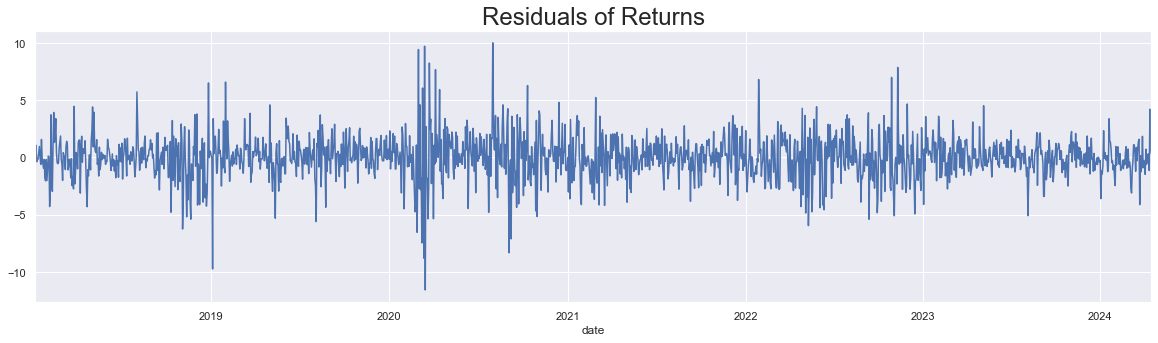

In [64]:
aapl.res_ret_ma_9[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [65]:
sts.adfuller(aapl.res_ret_ma_9[1:])

(-40.583795364324935,
 0.0,
 0,
 1637,
 {'1%': -3.434350967480226,
  '5%': -2.8633071969335333,
  '10%': -2.56771081609273},
 6658.325075542718)

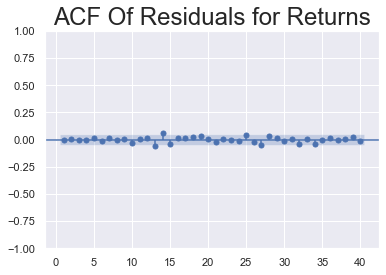

In [66]:
sgt.plot_acf(aapl.res_ret_ma_9[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

## ARMA

In [67]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2


def LLR_test(results1, results2, DF=1):
    L1 = results1.llf
    L2 = results2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_aic = np.inf
best_order = None
best_mdl = None

model_results = {}

for p in range(1, 5):  # p is the order of the AR component
    for q in range(1, 5):  # q is the order of the MA component
        try:
            model = ARIMA(aapl.returns, order=(p, 0, q))
            results = model.fit()
            model_results[(p, q)] = results
            print(f'ARMA({p},{q}) : AIC = {results.aic}')
        
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_mdl = results
        except Exception as e:
            print(f'Error fitting ARMA({p},{q}): {e}')
            continue

for (p, q), results in model_results.items():
    if (p, q) != best_order:
        p_value = LLR_test(best_mdl, results, DF=1)
        print(f'LLR test p-value ARMA{best_order} vs ARMA({p},{q}) = {p_value}')

print(f'Best ARMA model: ARMA{best_order} with AIC: {best_aic}')

print(best_mdl.summary())


ARMA(1,1) : AIC = 6806.503376082545
ARMA(1,2) : AIC = 6808.50636905003
ARMA(1,3) : AIC = 6810.331349486203
ARMA(1,4) : AIC = 6811.3435908273805
ARMA(2,1) : AIC = 6808.474587373388
ARMA(2,2) : AIC = 6810.50083332137
ARMA(2,3) : AIC = 6811.873575107305
ARMA(2,4) : AIC = 6808.452708781493
ARMA(3,1) : AIC = 6810.318018429709
ARMA(3,2) : AIC = 6806.29584133582
ARMA(3,3) : AIC = 6808.046010713596
ARMA(3,4) : AIC = 6794.744581769311
ARMA(4,1) : AIC = 6811.458989358889
ARMA(4,2) : AIC = 6807.9727102319575
ARMA(4,3) : AIC = 6810.25900946748
ARMA(4,4) : AIC = 6783.842289289641
LLR test p-value ARMA(4, 4) vs ARMA(1,1) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(1,2) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(1,3) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(1,4) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,1) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,2) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,3) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,4) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(3,1) = 1.0
LLR

In [68]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2


def LLR_test(results1, results2, DF=1):
    L1 = results1.llf
    L2 = results2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_aic = np.inf
best_order = None
best_mdl = None

model_results = {}

for p in range(1, 5):  # p is the order of the AR component
    for q in range(1, 5):  # q is the order of the MA component
        try:
            model = ARIMA(nikkei.returns, order=(p, 0, q))
            results = model.fit()
            model_results[(p, q)] = results
            print(f'ARMA({p},{q}) : AIC = {results.aic}')
        
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_mdl = results
        except Exception as e:
            print(f'Error fitting ARMA({p},{q}): {e}')
            continue

for (p, q), results in model_results.items():
    if (p, q) != best_order:
        p_value = LLR_test(best_mdl, results, DF=1)
        print(f'LLR test p-value ARMA{best_order} vs ARMA({p},{q}) = {p_value}')

print(f'Best ARMA model: ARMA{best_order} with AIC: {best_aic}')

print(best_mdl.summary())


ARMA(1,1) : AIC = 5177.442947208743
ARMA(1,2) : AIC = 5174.135388644587
ARMA(1,3) : AIC = 5176.037657864077
ARMA(1,4) : AIC = 5175.308888568359
ARMA(2,1) : AIC = 5174.366219816151
ARMA(2,2) : AIC = 5175.987683761119
ARMA(2,3) : AIC = 5177.973831258332
ARMA(2,4) : AIC = 5177.552111545394
ARMA(3,1) : AIC = 5176.245762837618
ARMA(3,2) : AIC = 5173.553713581676
ARMA(3,3) : AIC = 5175.1695876337835
ARMA(3,4) : AIC = 5177.463557943574
ARMA(4,1) : AIC = 5175.55814077056
ARMA(4,2) : AIC = 5175.70779522888
ARMA(4,3) : AIC = 5179.331860032691
ARMA(4,4) : AIC = 5176.449026221639
LLR test p-value ARMA(3, 2) vs ARMA(1,1) = 1.0
LLR test p-value ARMA(3, 2) vs ARMA(1,2) = 1.0
LLR test p-value ARMA(3, 2) vs ARMA(1,3) = 1.0
LLR test p-value ARMA(3, 2) vs ARMA(1,4) = 1.0
LLR test p-value ARMA(3, 2) vs ARMA(2,1) = 1.0
LLR test p-value ARMA(3, 2) vs ARMA(2,2) = 1.0
LLR test p-value ARMA(3, 2) vs ARMA(2,3) = 1.0
LLR test p-value ARMA(3, 2) vs ARMA(2,4) = 1.0
LLR test p-value ARMA(3, 2) vs ARMA(3,1) = 1.0
LL

In [69]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2


def LLR_test(results1, results2, DF=1):
    L1 = results1.llf
    L2 = results2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_aic = np.inf
best_order = None
best_mdl = None

model_results = {}

for p in range(1, 5):  # p is the order of the AR component
    for q in range(1, 5):  # q is the order of the MA component
        try:
            model = ARIMA(ftse.returns, order=(p, 0, q))
            results = model.fit()
            model_results[(p, q)] = results
            print(f'ARMA({p},{q}) : AIC = {results.aic}')
        
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_mdl = results
        except Exception as e:
            print(f'Error fitting ARMA({p},{q}): {e}')
            continue

for (p, q), results in model_results.items():
    if (p, q) != best_order:
        p_value = LLR_test(best_mdl, results, DF=1)
        print(f'LLR test p-value ARMA{best_order} vs ARMA({p},{q}) = {p_value}')

print(f'Best ARMA model: ARMA{best_order} with AIC: {best_aic}')

print(best_mdl.summary())


ARMA(1,1) : AIC = 4761.167615825161
ARMA(1,2) : AIC = 4763.075199122555
ARMA(1,3) : AIC = 4762.651998055344
ARMA(1,4) : AIC = 4752.7951292037305
ARMA(2,1) : AIC = 4763.088292800163
ARMA(2,2) : AIC = 4765.16344268356
ARMA(2,3) : AIC = 4736.695645603029
ARMA(2,4) : AIC = 4726.980368275372
ARMA(3,1) : AIC = 4764.258353753461
ARMA(3,2) : AIC = 4754.080162180804
ARMA(3,3) : AIC = 4742.709496337677
ARMA(3,4) : AIC = 4725.842531259294
ARMA(4,1) : AIC = 4765.230645695655
ARMA(4,2) : AIC = 4755.653713629565
ARMA(4,3) : AIC = 4757.306994505626
ARMA(4,4) : AIC = 4727.753783619895
LLR test p-value ARMA(3, 4) vs ARMA(1,1) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(1,2) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(1,3) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(1,4) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(2,1) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(2,2) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(2,3) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(2,4) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(3,1) = 1.0
L

In [70]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2


def LLR_test(results1, results2, DF=1):
    L1 = results1.llf
    L2 = results2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_aic = np.inf
best_order = None
best_mdl = None

model_results = {}

for p in range(1, 5):  # p is the order of the AR component
    for q in range(1, 5):  # q is the order of the MA component
        try:
            model = ARIMA(spx.returns, order=(p, 0, q))
            results = model.fit()
            model_results[(p, q)] = results
            print(f'ARMA({p},{q}) : AIC = {results.aic}')
        
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_mdl = results
        except Exception as e:
            print(f'Error fitting ARMA({p},{q}): {e}')
            continue

for (p, q), results in model_results.items():
    if (p, q) != best_order:
        p_value = LLR_test(best_mdl, results, DF=1)
        print(f'LLR test p-value ARMA{best_order} vs ARMA({p},{q}) = {p_value}')

print(f'Best ARMA model: ARMA{best_order} with AIC: {best_aic}')

print(best_mdl.summary())


ARMA(1,1) : AIC = 5360.984784511548
ARMA(1,2) : AIC = 5359.805937841174
ARMA(1,3) : AIC = 5360.084342000971
ARMA(1,4) : AIC = 5327.487528295955
ARMA(2,1) : AIC = 5360.553018371279
ARMA(2,2) : AIC = 5281.158496879334
ARMA(2,3) : AIC = 5356.619571997571
ARMA(2,4) : AIC = 5282.541779385018
ARMA(3,1) : AIC = 5362.560657230911
ARMA(3,2) : AIC = 5352.498954484302
ARMA(3,3) : AIC = 5282.7805715681325
ARMA(3,4) : AIC = 5282.6933228273465
ARMA(4,1) : AIC = 5307.901275950266
ARMA(4,2) : AIC = 5283.369283014976
ARMA(4,3) : AIC = 5285.977886288105
ARMA(4,4) : AIC = 5278.084002213431
LLR test p-value ARMA(4, 4) vs ARMA(1,1) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(1,2) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(1,3) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(1,4) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,1) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,2) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,3) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,4) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(3,1) = 1.0

In [71]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2


def LLR_test(results1, results2, DF=1):
    L1 = results1.llf
    L2 = results2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_aic = np.inf
best_order = None
best_mdl = None

model_results = {}

for p in range(1, 5):  # p is the order of the AR component
    for q in range(1, 5):  # q is the order of the MA component
        try:
            model = ARIMA(amd.returns, order=(p, 0, q))
            results = model.fit()
            model_results[(p, q)] = results
            print(f'ARMA({p},{q}) : AIC = {results.aic}')
        
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_mdl = results
        except Exception as e:
            print(f'Error fitting ARMA({p},{q}): {e}')
            continue

for (p, q), results in model_results.items():
    if (p, q) != best_order:
        p_value = LLR_test(best_mdl, results, DF=1)
        print(f'LLR test p-value ARMA{best_order} vs ARMA({p},{q}) = {p_value}')

print(f'Best ARMA model: ARMA{best_order} with AIC: {best_aic}')

print(best_mdl.summary())


ARMA(1,1) : AIC = 8677.105020366249
ARMA(1,2) : AIC = 8678.940943602705
ARMA(1,3) : AIC = 8678.622057536637
ARMA(1,4) : AIC = 8679.338518136188
ARMA(2,1) : AIC = 8678.965866985318
ARMA(2,2) : AIC = 8681.104586721916
ARMA(2,3) : AIC = 8680.238850381218
ARMA(2,4) : AIC = 8673.359885555641
ARMA(3,1) : AIC = 8678.888263493967
ARMA(3,2) : AIC = 8680.398139055971
ARMA(3,3) : AIC = 8673.743638869058
ARMA(3,4) : AIC = 8675.033518069842
ARMA(4,1) : AIC = 8680.888261419426
ARMA(4,2) : AIC = 8673.627011606011
ARMA(4,3) : AIC = 8675.050269800067
ARMA(4,4) : AIC = 8670.177024315833
LLR test p-value ARMA(4, 4) vs ARMA(1,1) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(1,2) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(1,3) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(1,4) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,1) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,2) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,3) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(2,4) = 1.0
LLR test p-value ARMA(4, 4) vs ARMA(3,1) = 1.0
L

In [72]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2


def LLR_test(results1, results2, DF=1):
    L1 = results1.llf
    L2 = results2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_aic = np.inf
best_order = None
best_mdl = None

model_results = {}

for p in range(1, 5):  # p is the order of the AR component
    for q in range(1, 5):  # q is the order of the MA component
        try:
            model = ARIMA(amzn.returns, order=(p, 0, q))
            results = model.fit()
            model_results[(p, q)] = results
            print(f'ARMA({p},{q}) : AIC = {results.aic}')
        
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_mdl = results
        except Exception as e:
            print(f'Error fitting ARMA({p},{q}): {e}')
            continue

for (p, q), results in model_results.items():
    if (p, q) != best_order:
        p_value = LLR_test(best_mdl, results, DF=1)
        print(f'LLR test p-value ARMA{best_order} vs ARMA({p},{q}) = {p_value}')

print(f'Best ARMA model: ARMA{best_order} with AIC: {best_aic}')

print(best_mdl.summary())


ARMA(1,1) : AIC = 7185.869276809264
ARMA(1,2) : AIC = 7187.410972904287
ARMA(1,3) : AIC = 7188.137367194384
ARMA(1,4) : AIC = 7188.596522303973
ARMA(2,1) : AIC = 7187.8728358356375
ARMA(2,2) : AIC = 7188.440578633576
ARMA(2,3) : AIC = 7181.002616058606
ARMA(2,4) : AIC = 7190.564566202165
ARMA(3,1) : AIC = 7188.164299463913
ARMA(3,2) : AIC = 7185.414112879933
ARMA(3,3) : AIC = 7185.778142874135
ARMA(3,4) : AIC = 7188.9951376341705
ARMA(4,1) : AIC = 7188.881532845777
ARMA(4,2) : AIC = 7190.8150784355885
ARMA(4,3) : AIC = 7189.863880827146
ARMA(4,4) : AIC = 7187.544648959803
LLR test p-value ARMA(2, 3) vs ARMA(1,1) = 1.0
LLR test p-value ARMA(2, 3) vs ARMA(1,2) = 1.0
LLR test p-value ARMA(2, 3) vs ARMA(1,3) = 1.0
LLR test p-value ARMA(2, 3) vs ARMA(1,4) = 1.0
LLR test p-value ARMA(2, 3) vs ARMA(2,1) = 1.0
LLR test p-value ARMA(2, 3) vs ARMA(2,2) = 1.0
LLR test p-value ARMA(2, 3) vs ARMA(2,4) = 1.0
LLR test p-value ARMA(2, 3) vs ARMA(3,1) = 1.0
LLR test p-value ARMA(2, 3) vs ARMA(3,2) = 1.

In [73]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2


def LLR_test(results1, results2, DF=1):
    L1 = results1.llf
    L2 = results2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF)
    return p

best_aic = np.inf
best_order = None
best_mdl = None

model_results = {}

for p in range(1, 5):  # p is the order of the AR component
    for q in range(1, 5):  # q is the order of the MA component
        try:
            model = ARIMA(goog.returns, order=(p, 0, q))
            results = model.fit()
            model_results[(p, q)] = results
            print(f'ARMA({p},{q}) : AIC = {results.aic}')
        
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_mdl = results
        except Exception as e:
            print(f'Error fitting ARMA({p},{q}): {e}')
            continue

for (p, q), results in model_results.items():
    if (p, q) != best_order:
        p_value = LLR_test(best_mdl, results, DF=1)
        print(f'LLR test p-value ARMA{best_order} vs ARMA({p},{q}) = {p_value}')

print(f'Best ARMA model: ARMA{best_order} with AIC: {best_aic}')

print(best_mdl.summary())


ARMA(1,1) : AIC = 6785.379100686658
ARMA(1,2) : AIC = 6784.373992653679
ARMA(1,3) : AIC = 6786.2245878689155
ARMA(1,4) : AIC = 6785.837466779183
ARMA(2,1) : AIC = 6784.273894202518
ARMA(2,2) : AIC = 6786.200555498174
ARMA(2,3) : AIC = 6786.291854340654
ARMA(2,4) : AIC = 6787.01416212059
ARMA(3,1) : AIC = 6786.21033789024
ARMA(3,2) : AIC = 6785.757403719036
ARMA(3,3) : AIC = 6766.382243220044
ARMA(3,4) : AIC = 6765.045124313707
ARMA(4,1) : AIC = 6788.186205277874
ARMA(4,2) : AIC = 6786.404328332853
ARMA(4,3) : AIC = 6765.384590770382
ARMA(4,4) : AIC = 6765.349167794313
LLR test p-value ARMA(3, 4) vs ARMA(1,1) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(1,2) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(1,3) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(1,4) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(2,1) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(2,2) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(2,3) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(2,4) = 1.0
LLR test p-value ARMA(3, 4) vs ARMA(3,1) = 1.0
LL

# THE BEST MODELS

## For Apple

In [77]:
df_comp = df.copy()

In [78]:
df_comp

symbol,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,meta,msft,nflx,nvda,tsla
date,,,,,,,,,,,,,,,
2018-01-02,23506.330078,7648.100098,2695.810059,40.670975,10.980000,59.450500,53.250000,222.359329,109.547676,89.602852,181.227707,80.080910,201.070007,49.310482,21.368668
2018-01-03,23506.330078,7671.100098,2713.060059,40.663898,11.550000,60.209999,54.124001,220.289352,112.558929,89.694145,184.474274,80.453613,205.050003,52.555790,21.150000
2018-01-04,23506.330078,7695.899902,2723.989990,40.852768,12.120000,60.479500,54.320000,223.368134,114.838638,90.979080,184.134628,81.161697,205.630005,52.832829,20.974667
2018-01-05,23714.529297,7724.200195,2743.149902,41.317894,11.880000,61.457001,55.111500,222.228882,115.399681,90.395004,186.651962,82.167976,209.990005,53.280544,21.105333
2018-01-08,23714.529297,7696.500000,2747.709961,41.164429,12.280000,62.343498,55.347000,219.002228,116.095711,90.528519,188.080444,82.251823,212.050003,54.913105,22.427334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-09,39773.128906,7934.799805,5209.910156,169.669998,170.779999,185.669998,158.139999,410.709991,189.309998,197.149994,516.900024,426.279999,618.200012,853.539978,176.880005
2024-04-10,39581.808594,7961.200195,5160.640137,167.779999,167.139999,185.949997,157.660004,400.760010,186.039993,195.470001,519.830017,423.260010,618.580017,870.390015,171.759995
2024-04-11,39442.628906,7923.799805,5199.060059,175.039993,170.500000,189.050003,160.789993,397.480011,185.899994,195.429993,523.159973,427.929993,628.780029,906.159973,174.600006


In [79]:
df_comp=df_comp.asfreq('d')

In [80]:
df_comp= df_comp.fillna(method = "ffill")

In [81]:
df_comp = df_comp.iloc[1:]

In [82]:
df_comp["ret_spx"] = df_comp.spx.pct_change(1).mul(100)
df_comp["ret_aapl"] = df_comp.aapl.pct_change(1).mul(100)
df_comp["ret_nikkei"] = df_comp.nikkei.pct_change(1).mul(100)
df_comp["ret_ftse"] = df_comp.ftse.pct_change(1).mul(100)
df_comp["ret_amd"] = df_comp.amd.pct_change(1).mul(100)
df_comp["ret_amzn"] = df_comp.amzn.pct_change(1).mul(100)
df_comp["ret_goog"] = df_comp.goog.pct_change(1).mul(100)
df_comp = df_comp.iloc[1:]

In [83]:
size = int(len(df_comp)*0.8)
df_train, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [84]:
df_train.tail()

symbol,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,...,nflx,nvda,tsla,ret_spx,ret_aapl,ret_nikkei,ret_ftse,ret_amd,ret_amzn,ret_goog
date,,,,,,,,,,,,,,,,,,,,,
2023-01-08,25973.849609,7699.500000,3895.080078,128.735245,63.959999,86.080002,88.160004,335.012848,135.663956,133.331955,...,315.549988,148.517120,113.059998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-09,25973.849609,7724.899902,3892.090088,129.261627,67.239998,87.360001,88.800003,339.748138,135.522354,132.781006,...,315.170013,156.203369,119.769997,-0.076763,0.408888,0.000000,0.329890,5.128203,1.486987,0.725952
2023-01-10,26175.560547,7694.500000,3919.250000,129.837646,68.050003,89.870003,89.239998,343.944458,136.702454,133.969894,...,327.540009,159.011978,118.849998,0.697823,0.445623,0.776592,-0.393531,1.204648,2.873171,0.495490
2023-01-11,26446.000000,7725.000000,3969.610107,132.578842,69.059998,95.089996,92.260002,350.797211,137.136734,134.965515,...,327.260010,159.931503,123.220001,1.284942,2.111249,1.033175,0.396387,1.484195,5.808383,3.384138
2023-01-12,26449.820312,7794.000000,3983.169922,132.499390,70.800003,95.269997,91.910004,356.052185,137.410522,134.830185,...,330.130005,165.029053,123.559998,0.341591,-0.059929,0.014446,0.893204,2.519556,0.189295,-0.379361


In [85]:
start_date = "2022-06-20"
end_date = "2022-06-24"

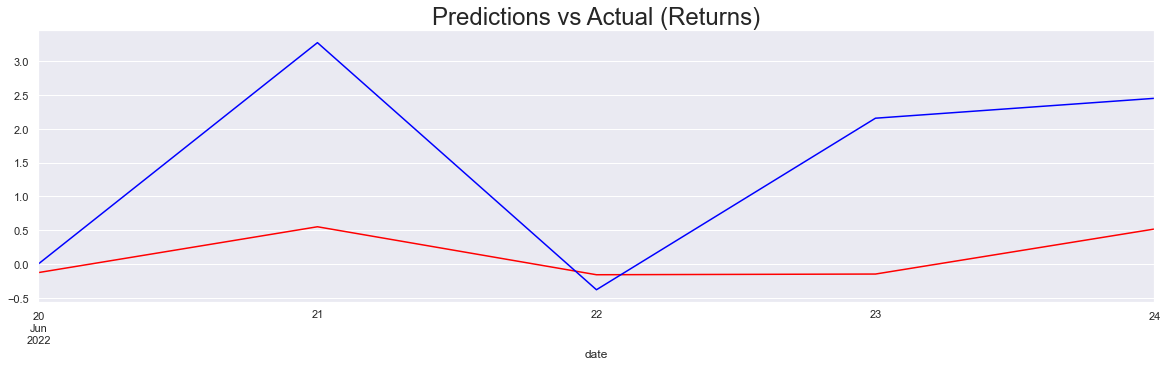

In [ ]:
model_ret_ar_9 = ARIMA(df_train.ret_aapl, order = (9,0,0))
results_ret_ar_9 = model_ret_ar_9.fit()
df_pred_ar_9 = results_ret_ar_9.predict(start =start_date, end = end_date)

df_pred_ar_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_aapl[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_ar_9 = mean_squared_error(df_pred_ar_9[start_date:end_date],df_test.ret_aapl[start_date:end_date])
model_ret_ar_9

3.3137332507158055

In [ ]:
model_ret_ar = mean_squared_error(df_pred_ar[start_date:end_date],df_test.ret_aapl[start_date:end_date])
model_ret_ar

4.058068785990811

### Fitting MA model

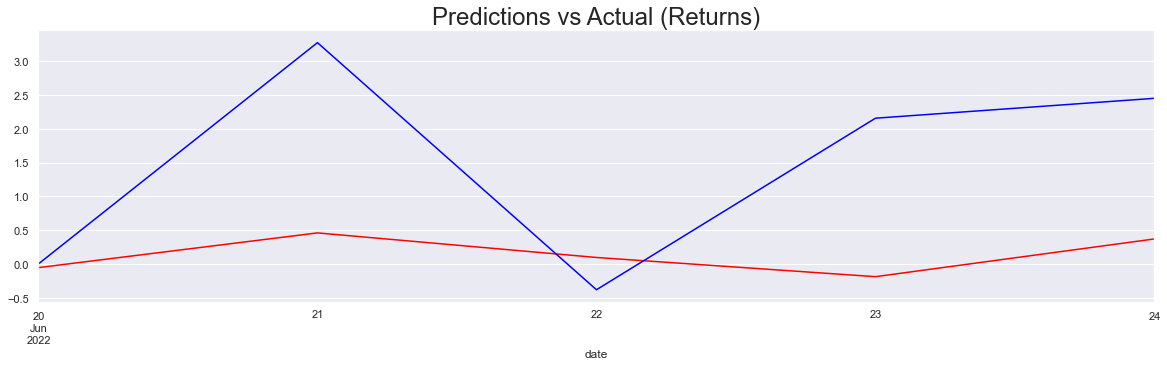

In [ ]:
model_ret_ma_8 = ARIMA(df_train.ret_aapl, order = (0,0,8))
results_ret_ma_8 = model_ret_ma_8.fit()
df_pred_ma_8 = results_ret_ma_8.predict(start =start_date, end = end_date)

df_pred_ma_8[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_aapl[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_ma_8 = mean_squared_error(df_pred_ma_8[start_date:end_date],df_test.ret_aapl[start_date:end_date])
model_ret_ma_8

3.6017287420731194

### Fitting ARMA models

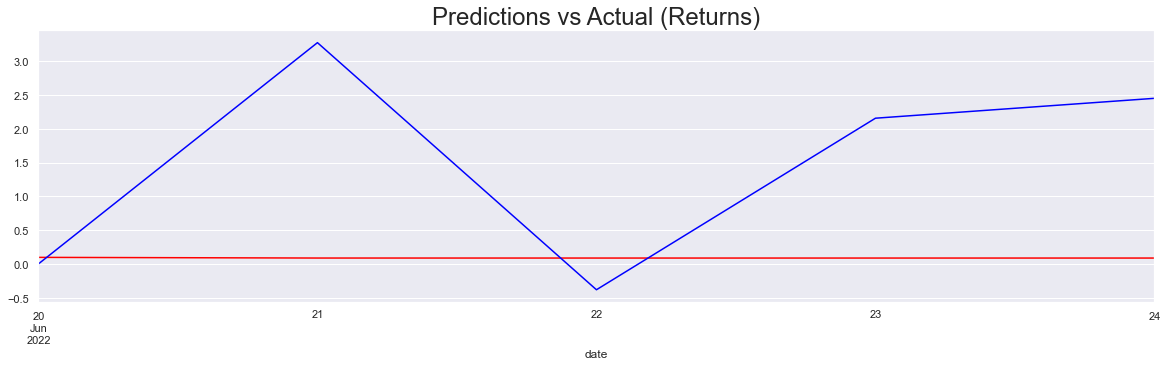

In [ ]:
model_ret_ar_1_ma_1 = ARIMA(df_train.ret_aapl, order = (1,0,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
df_pred_ar_1_ma_1 = results_ret_ar_1_ma_1.predict(start =start_date, end = end_date)

df_pred_ar_1_ma_1[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_aapl[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_ar_1_ma_1 = mean_squared_error(df_pred_ar_1_ma_1[start_date:end_date],df_test.ret_aapl[start_date:end_date])
model_ret_ar_1_ma_1

4.056550960614608

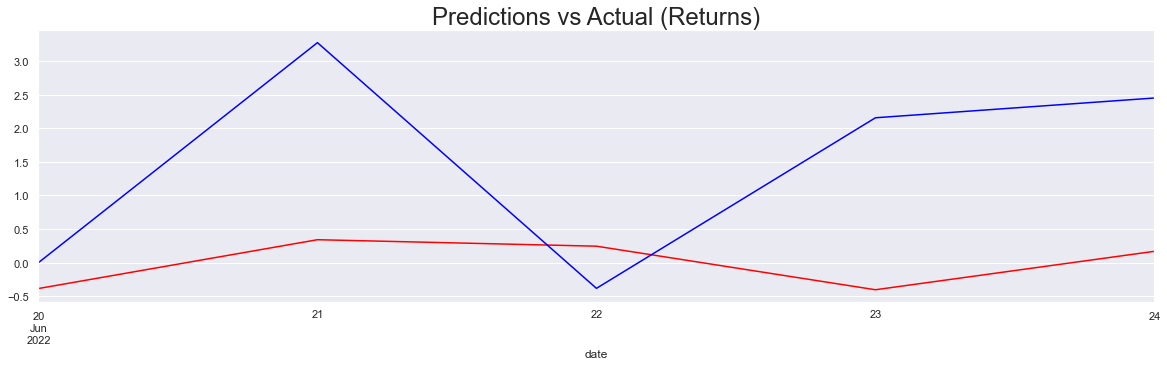

In [ ]:
model_ret_ar_4_ma_4 = ARIMA(df_train.ret_aapl, order = (4,0,4))
results_ret_ar_4_ma_4 = model_ret_ar_4_ma_4.fit()
df_pred_ar_4_ma_4 = results_ret_ar_4_ma_4.predict(start =start_date, end = end_date)

df_pred_ar_4_ma_4[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_aapl[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_ar_4_ma_4 = mean_squared_error(df_pred_ar_4_ma_4[start_date:end_date],df_test.ret_aapl[start_date:end_date])
model_ret_ar_4_ma_4

4.185031232870424

In [ ]:
df_pred_ar_4_ma_4.head()

2022-06-20   -0.276720
2022-06-21    0.260553
2022-06-22    0.194263
2022-06-23   -0.293443
2022-06-24    0.131292
Freq: D, Name: predicted_mean, dtype: float64

### ARMAX

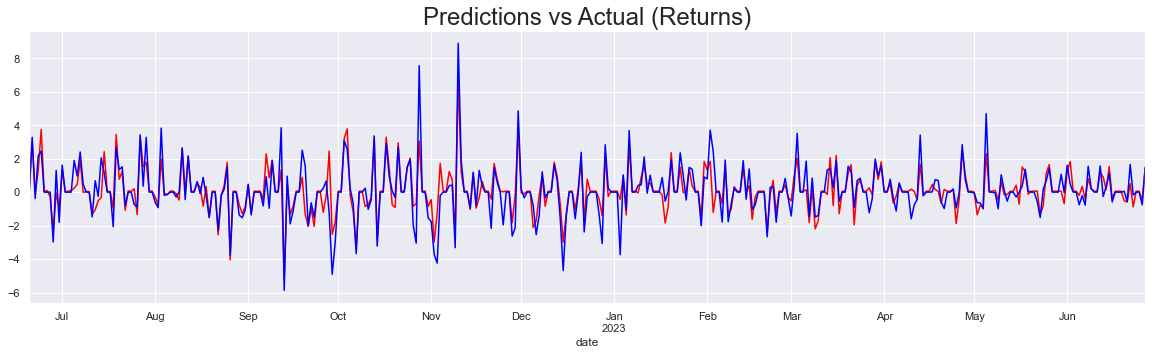

In [ ]:
end_date = "2023-06-27"

model_ret_armax = ARIMA(df_train.ret_aapl[1:], exog = df_train[["ret_spx"]][1:], order = (4,0,4))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test["ret_spx"][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_aapl[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

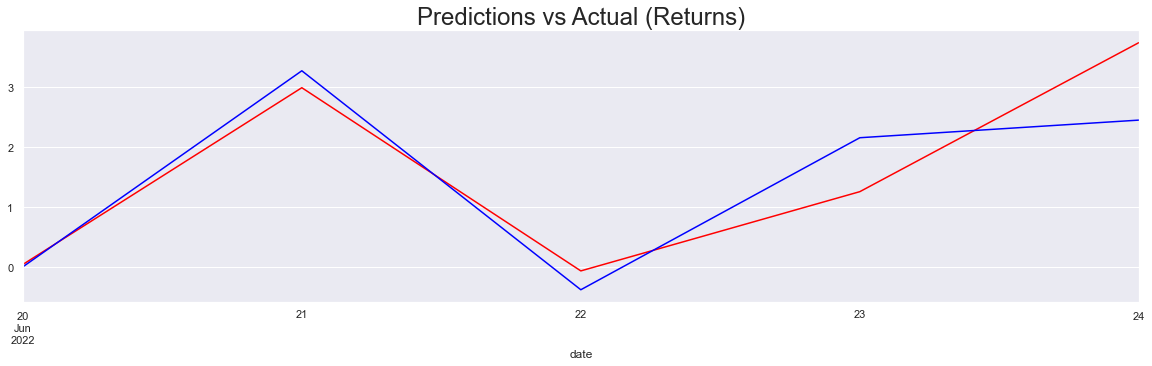

In [ ]:
end_date = "2022-06-24"
model_ret_armax = ARIMA(df_train.ret_aapl[1:], exog = df_train[["ret_spx"]][1:], order = (4,0,4))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test["ret_spx"][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_aapl[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_armax = mean_squared_error(df_pred_armax[start_date:end_date],df_test.ret_aapl[start_date:end_date])
model_ret_armax

0.5335716767523417

In [ ]:
df_pred_armax.head()

2022-06-20    0.036128
2022-06-21    2.987674
2022-06-22   -0.075997
2022-06-23    1.252446
2022-06-24    3.742332
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
df_pred_armax.mean()

1.5885165618508263

In [ ]:
dict_of_returns = {df_pred_armax.mean()}

## For Nikkei

### Fitting AR model

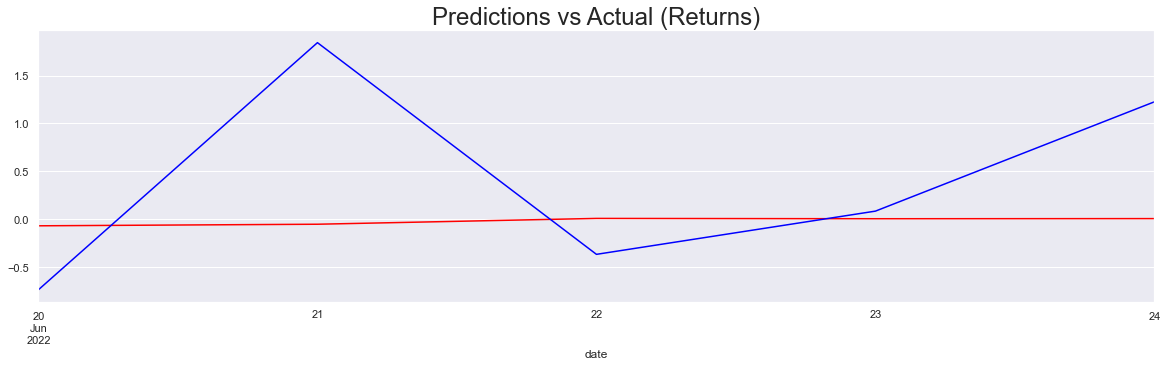

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 

model_ret_ar = ARIMA(df_train.ret_nikkei, order = (4,0,0))
results_ret_ar = model_ret_ar.fit()
df_pred_ar = results_ret_ar.predict(start =start_date, end = end_date)

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_nikkei[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

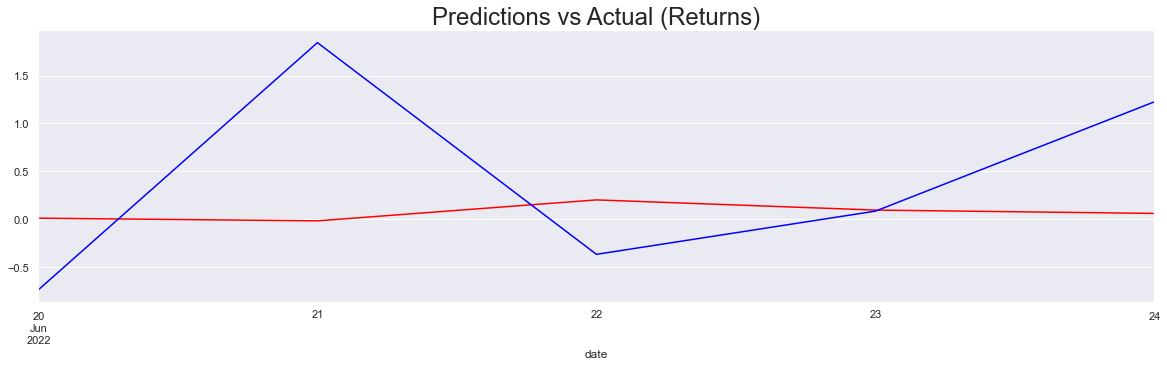

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 

model_ret_ar9 = ARIMA(df_train.ret_nikkei, order = (9,0,0))
results_ret_ar9 = model_ret_ar9.fit()
df_pred_ar9 = results_ret_ar9.predict(start =start_date, end = end_date)

df_pred_ar9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_nikkei[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_ar = mean_squared_error(df_pred_ar[start_date:end_date],df_test.ret_nikkei[start_date:end_date])
model_ret_ar

1.142268683090534

In [ ]:
model_ret_ar9 = mean_squared_error(df_pred_ar9[start_date:end_date],df_test.ret_nikkei[start_date:end_date])
model_ret_ar9

1.142268683090534

### Fitting MA model

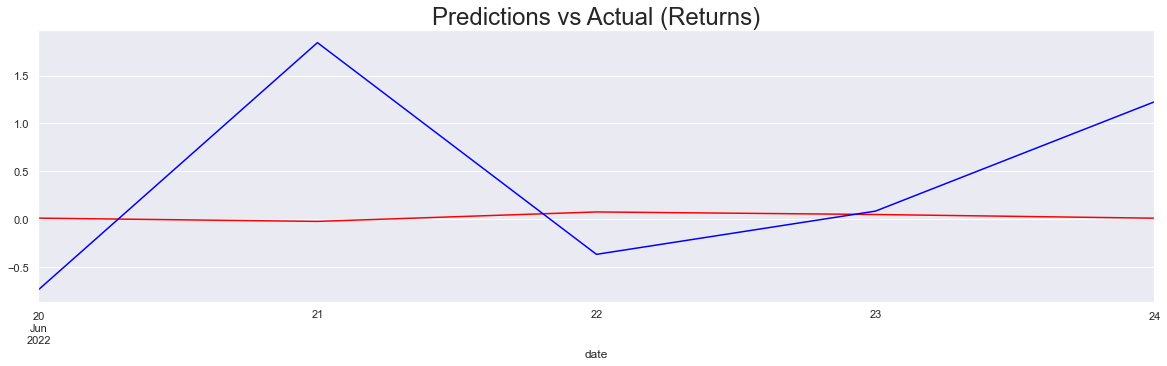

In [ ]:
model_ret_ma_8 = ARIMA(df_train.ret_nikkei, order = (0,0,8))
results_ret_ma_8 = model_ret_ma_8.fit()
df_pred_ma_8 = results_ret_ma_8.predict(start =start_date, end = end_date)

df_pred_ma_8[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_nikkei[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_ma_8 = mean_squared_error(df_pred_ma_8[start_date:end_date],df_test.ret_nikkei[start_date:end_date])
model_ret_ma_8

1.1452852729865621

### Fitting ARMA models

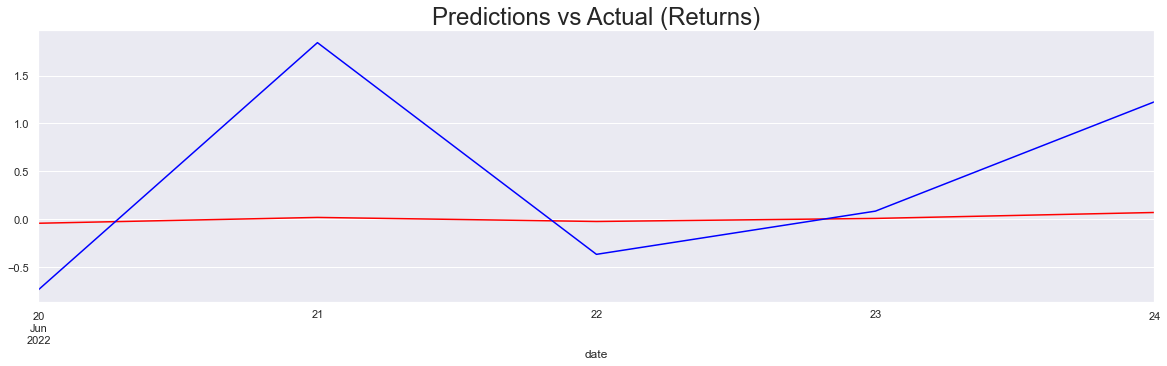

In [ ]:
model_ret_ar_4_ma_4 = ARIMA(df_train.ret_nikkei, order = (4,0,4))
results_ret_ar_4_ma_4 = model_ret_ar_4_ma_4.fit()
df_pred_ar_4_ma_4 = results_ret_ar_4_ma_4.predict(start =start_date, end = end_date)

df_pred_ar_4_ma_4[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_nikkei[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_ar_4_ma_4 = mean_squared_error(df_pred_ar_4_ma_4[start_date:end_date],df_test.ret_nikkei[start_date:end_date])
model_ret_ar_4_ma_4

1.056067933723083

### ARMAX

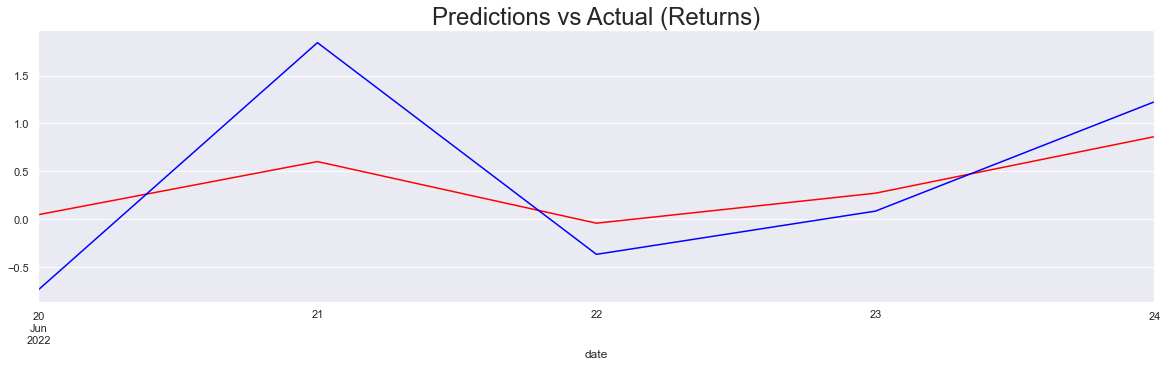

In [ ]:
model_ret_armax = ARIMA(df_train.ret_nikkei[1:], exog = df_train[["ret_spx"]][1:], order = (4,0,4))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test["ret_spx"][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_armax = mean_squared_error(df_pred_armax[start_date:end_date],df_test.ret_nikkei[start_date:end_date])
model_ret_armax

0.4867704915666036

In [ ]:
df_pred_armax.mean()

0.34699312893198175

## For ftse

### Fitting AR

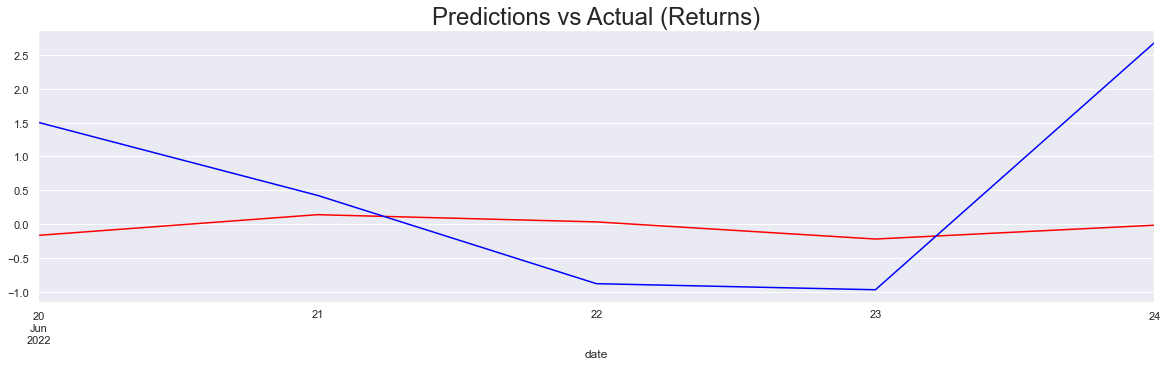

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 

model_ret_ar_7 = ARIMA(df_train.ret_ftse, order = (7,0,0))
results_ret_ar_7 = model_ret_ar_7.fit()
df_pred_ar_7 = results_ret_ar_7.predict(start =start_date, end = end_date)

df_pred_ar_7[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_ftse[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
model_ret_ar_7 = mean_squared_error(df_pred_ar_7[start_date:end_date],df_test.ret_ftse[start_date:end_date])
model_ret_ar_7

2.307846882289706

### Fitting MA

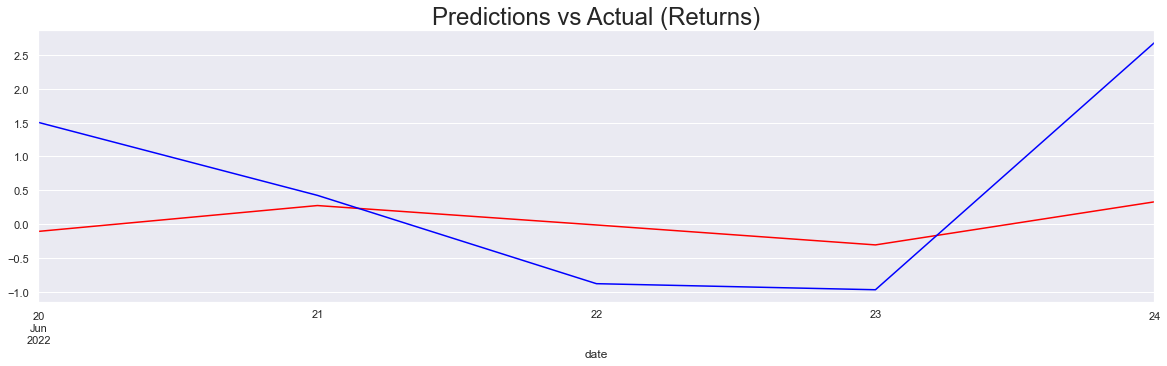

1.8679938944873853

In [ ]:
model_ret_ma_9 = ARIMA(df_train.ret_ftse, order = (0,0,9))
results_ret_ma_9 = model_ret_ma_9.fit()
df_pred_ma_9 = results_ret_ma_9.predict(start =start_date, end = end_date)

df_pred_ma_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_ftse[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ma_9 = mean_squared_error(df_pred_ma_9[start_date:end_date],df_test.ret_ftse[start_date:end_date])
model_ret_ma_9

## Fitting ARMA & ARMAX

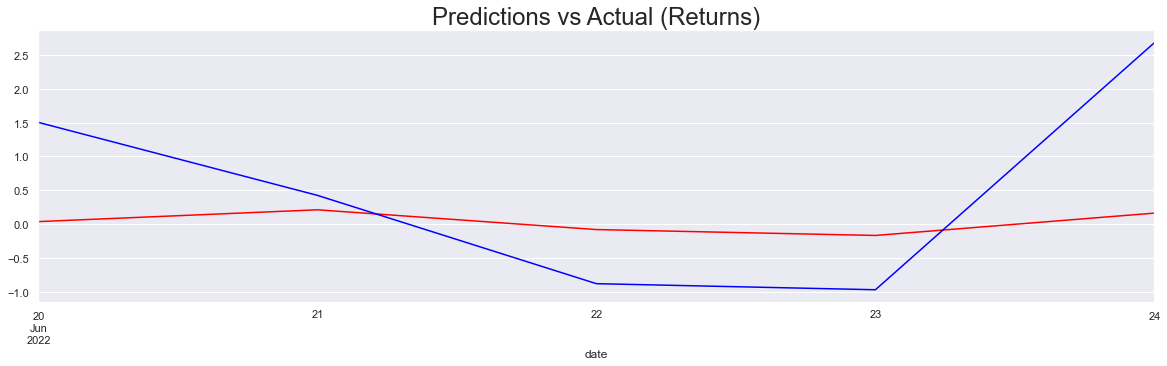

1.9643791321438837

In [ ]:
model_ret_ar_4_ma_4 = ARIMA(df_train.ret_ftse, order = (4,0,4))
results_ret_ar_4_ma_4 = model_ret_ar_4_ma_4.fit()
df_pred_ar_4_ma_4 = results_ret_ar_4_ma_4.predict(start =start_date, end = end_date)

df_pred_ar_4_ma_4[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_ftse[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ar_4_ma_4 = mean_squared_error(df_pred_ar_4_ma_4[start_date:end_date],df_test.ret_ftse[start_date:end_date])
model_ret_ar_4_ma_4

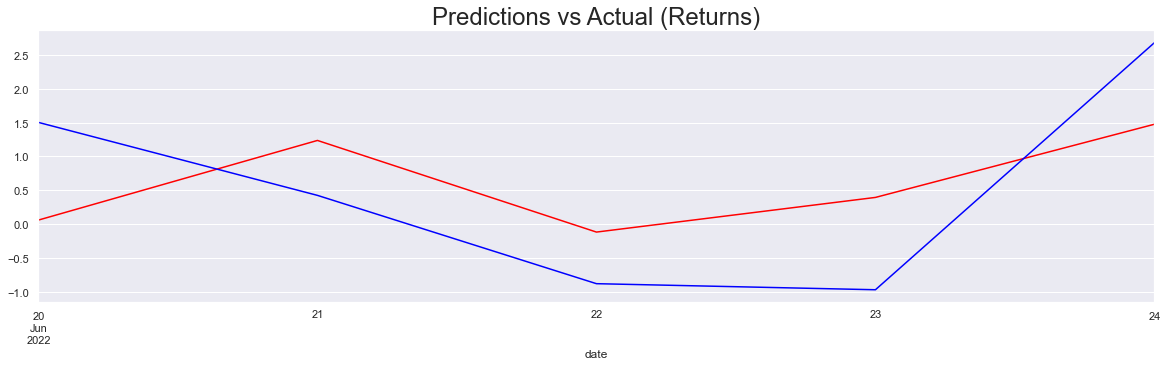

1.3274918428967895

In [ ]:
model_ret_armax = ARIMA(df_train.ret_ftse[1:], exog = df_train[["ret_spx"]][1:], order = (4,0,4))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test["ret_spx"][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_armax = mean_squared_error(df_pred_armax[start_date:end_date],df_test.ret_ftse[start_date:end_date])
model_ret_armax

In [ ]:
df_pred_armax.mean()

0.6105448735854448

## For Spx

### AR MA ARMA & ARMAX

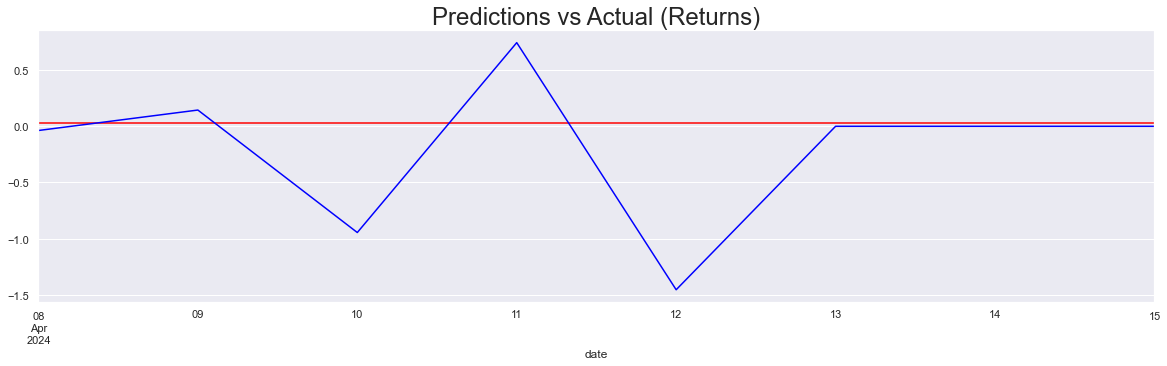

AR 0.4598779820370691


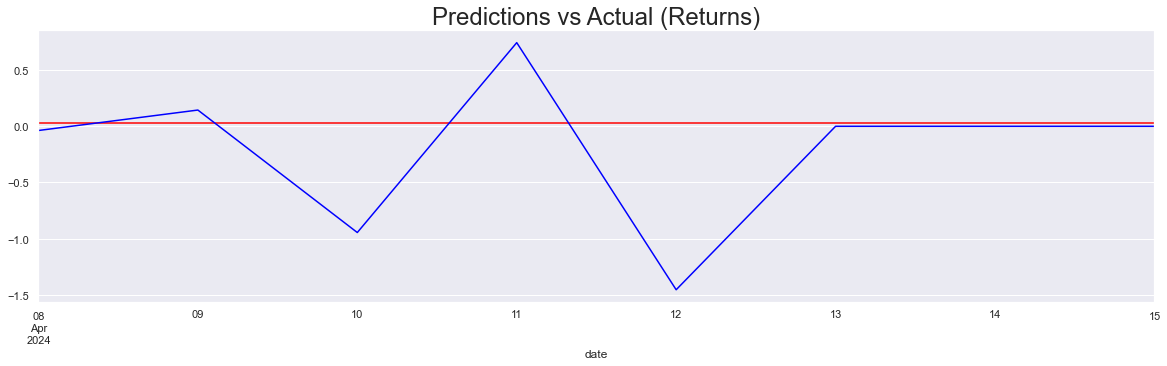

MA 0.4598983448600952


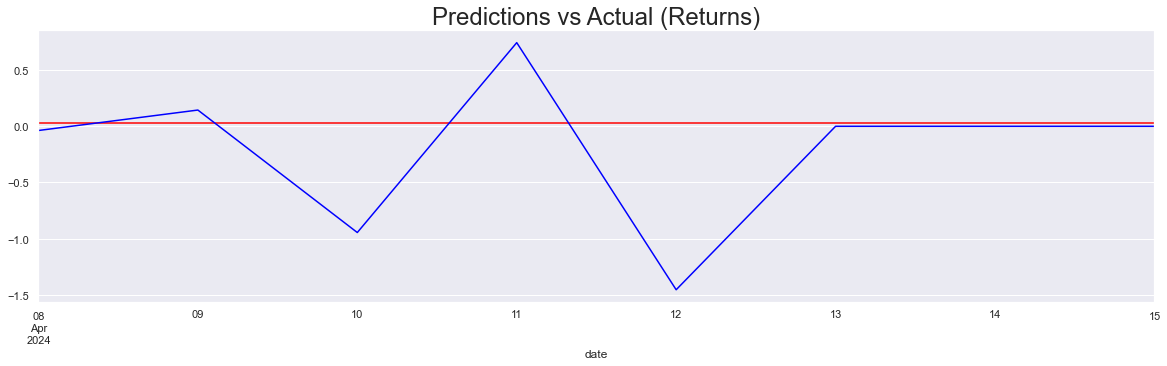

ARMA 0.46000895555225396


ValueError: Provided exogenous values are not of the appropriate shape. Required (459, 1), got (8,).

In [94]:
start_date = "2024-04-08"
end_date = "2024-04-15"
from statsmodels.tsa.arima.model import ARIMA 
#AR
model_ret_ar_9 = ARIMA(df_train.ret_spx, order = (9,0,0))
results_ret_ar_9 = model_ret_ar_9.fit()
df_pred_ar_9 = results_ret_ar_9.predict(start =start_date, end = end_date)

df_pred_ar_9[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_spx[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()


model_ret_ar_9 = mean_squared_error(df_pred_ar_9[start_date:end_date],df_test.ret_spx[start_date:end_date])
print("AR",model_ret_ar_9)

#MA
model_ret_ma_7 = ARIMA(df_train.ret_spx, order = (0,0,7))
results_ret_ma_7 = model_ret_ma_7.fit()
df_pred_ma_7 = results_ret_ma_7.predict(start =start_date, end = end_date)

df_pred_ma_7[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_spx[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ma_7 = mean_squared_error(df_pred_ma_7[start_date:end_date],df_test.ret_spx[start_date:end_date])
print("MA",model_ret_ma_7)

#ARMA
model_ret_ar_3_ma_3 = ARIMA(df_train.ret_spx, order = (3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
df_pred_ar_3_ma_3 = results_ret_ar_3_ma_3.predict(start =start_date, end = end_date)

df_pred_ar_3_ma_3[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_spx[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ar_3_ma_3 = mean_squared_error(df_pred_ar_3_ma_3[start_date:end_date],df_test.ret_spx[start_date:end_date])
print("ARMA",model_ret_ar_3_ma_3)

#ARMAX
model_ret_armax = ARIMA(df_train.ret_spx[1:], exog = df_train[["ret_goog"]][1:], order = (3,0,3))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test["ret_goog"][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_spx[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_armax = mean_squared_error(df_pred_armax[start_date:end_date],df_test.ret_spx[start_date:end_date])
print("ARMAX", model_ret_armax)

In [ ]:
df_pred_armax.mean()

1.11470734059486

## For Amzn

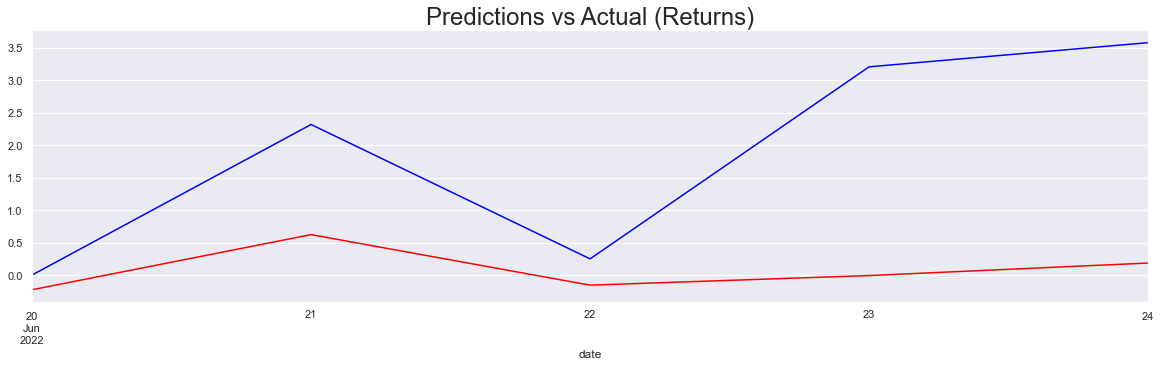

AR 4.979960365626765


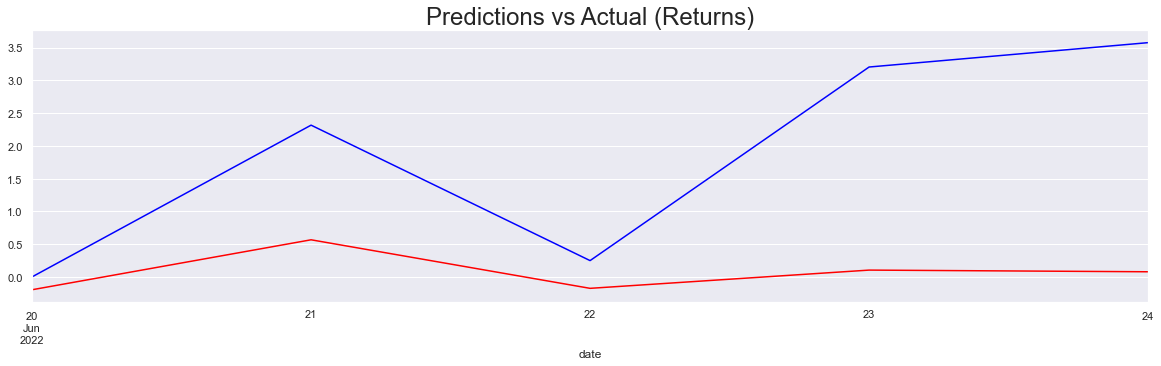

MA 5.023807744260018


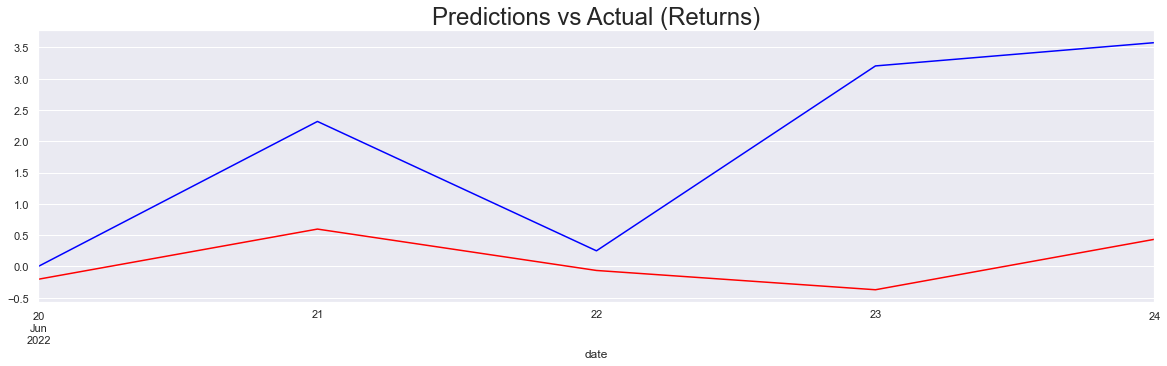

ARMA 5.154932907344716


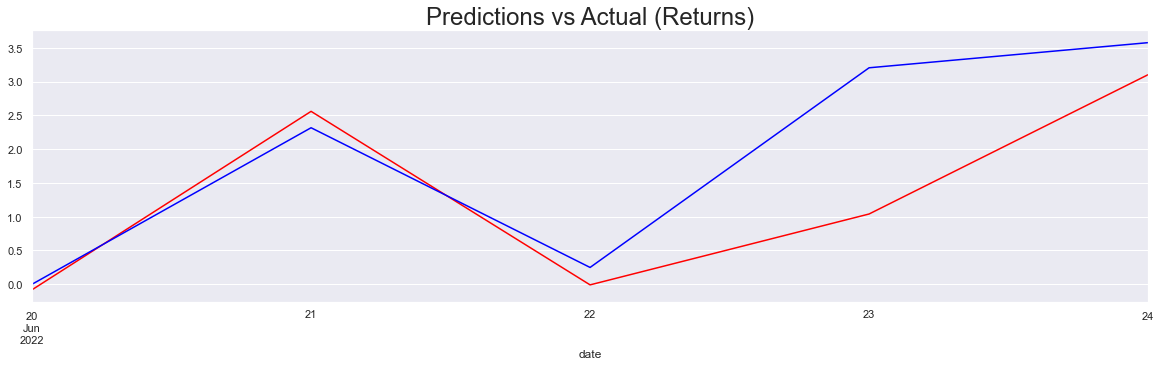

ARMAX 1.0078127060159452


1.321587776396055

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 
#AR
model_ret_ar_8 = ARIMA(df_train.ret_amzn, order = (8,0,0))
results_ret_ar_8 = model_ret_ar_8.fit()
df_pred_ar_8 = results_ret_ar_8.predict(start =start_date, end = end_date)

df_pred_ar_8[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amzn[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()


model_ret_ar_8 = mean_squared_error(df_pred_ar_8[start_date:end_date],df_test.ret_amzn[start_date:end_date])
print("AR",model_ret_ar_8)

#MA
model_ret_ma_8 = ARIMA(df_train.ret_amzn, order = (0,0,8))
results_ret_ma_8 = model_ret_ma_8.fit()
df_pred_ma_8 = results_ret_ma_8.predict(start =start_date, end = end_date)

df_pred_ma_8[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amzn[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ma_8 = mean_squared_error(df_pred_ma_8[start_date:end_date],df_test.ret_amzn[start_date:end_date])
print("MA",model_ret_ma_8)

#ARMA
model_ret_ar_2_ma_2 = ARIMA(df_train.ret_amzn, order = (2,0,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
df_pred_ar_2_ma_2 = results_ret_ar_2_ma_2.predict(start =start_date, end = end_date)

df_pred_ar_2_ma_2[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amzn[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ar_2_ma_2 = mean_squared_error(df_pred_ar_2_ma_2[start_date:end_date],df_test.ret_amzn[start_date:end_date])
print("ARMA",model_ret_ar_2_ma_2)

#ARMAX
model_ret_armax = ARIMA(df_train.ret_amzn[1:], exog = df_train[["ret_spx"]][1:], order = (2,0,2))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test["ret_spx"][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_amzn[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_armax = mean_squared_error(df_pred_armax[start_date:end_date],df_test.ret_amzn[start_date:end_date])
print("ARMAX", model_ret_armax)

df_pred_armax.mean()

# For Amd

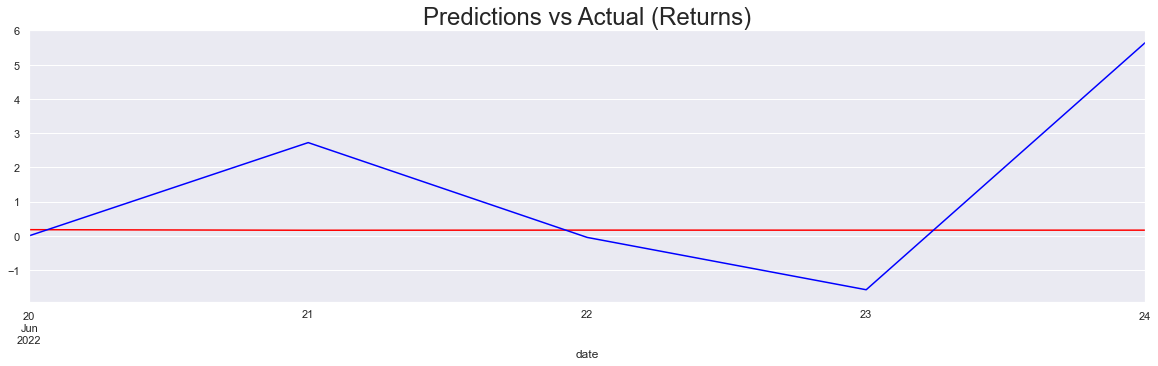

AR 7.930978934372854


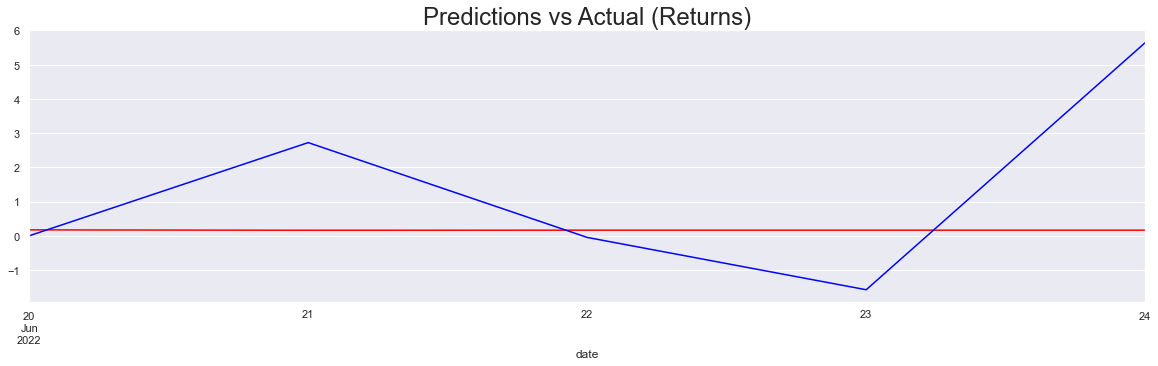

MA 7.931362327423183


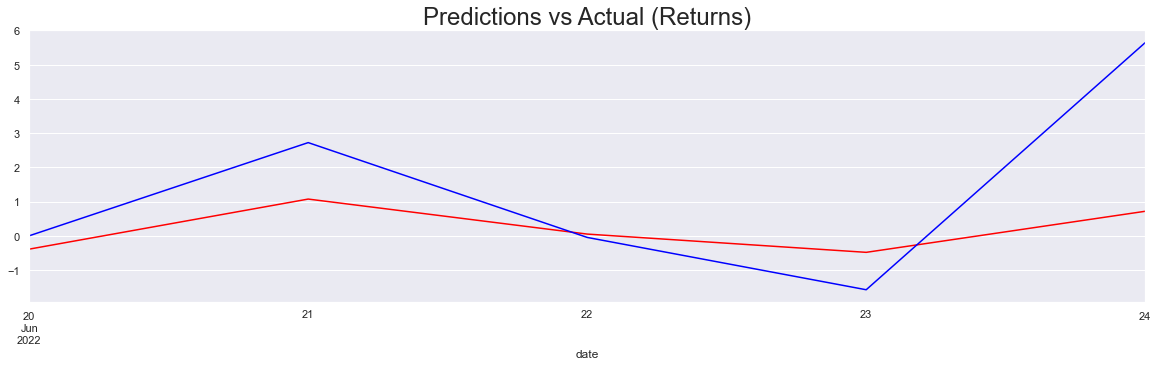

ARMA 5.666804980467927


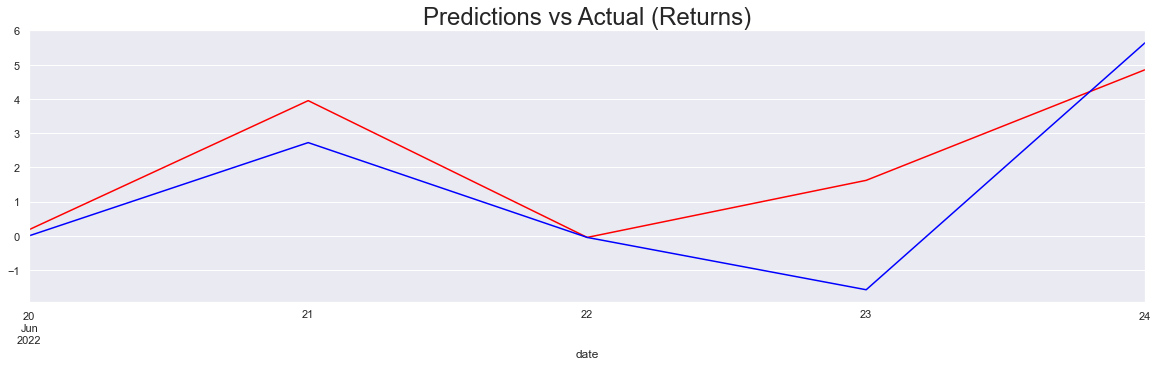

ARMAX 2.474333663257849


2.1103480242249373

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 
#AR
model_ret_ar_3 = ARIMA(df_train.ret_amd, order = (3,0,0))
results_ret_ar_3 = model_ret_ar_3.fit()
df_pred_ar_3 = results_ret_ar_3.predict(start =start_date, end = end_date)

df_pred_ar_3[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amd[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()


model_ret_ar_3 = mean_squared_error(df_pred_ar_3[start_date:end_date],df_test.ret_amd[start_date:end_date])
print("AR",model_ret_ar_3)

#MA
model_ret_ma_2 = ARIMA(df_train.ret_amd, order = (0,0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
df_pred_ma_2 = results_ret_ma_2.predict(start =start_date, end = end_date)

df_pred_ma_2[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amd[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ma_2 = mean_squared_error(df_pred_ma_2[start_date:end_date],df_test.ret_amd[start_date:end_date])
print("MA",model_ret_ma_2)

#ARMA
model_ret_ar_2_ma_2 = ARIMA(df_train.ret_amd, order = (4,0,4))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
df_pred_ar_2_ma_2 = results_ret_ar_2_ma_2.predict(start =start_date, end = end_date)

df_pred_ar_2_ma_2[start_date:end_date].plot(figsize = (20,5), color ="red")
df_test.ret_amd[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ar_2_ma_2 = mean_squared_error(df_pred_ar_2_ma_2[start_date:end_date],df_test.ret_amd[start_date:end_date])
print("ARMA",model_ret_ar_2_ma_2)

#ARMAX
model_ret_armax = ARIMA(df_train.ret_amd[1:], exog = df_train[["ret_spx"]][1:], order = (2,0,2))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test["ret_spx"][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_amd[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_armax = mean_squared_error(df_pred_armax[start_date:end_date],df_test.ret_amd[start_date:end_date])
print("ARMAX", model_ret_armax)

df_pred_armax.mean()

# For Goog

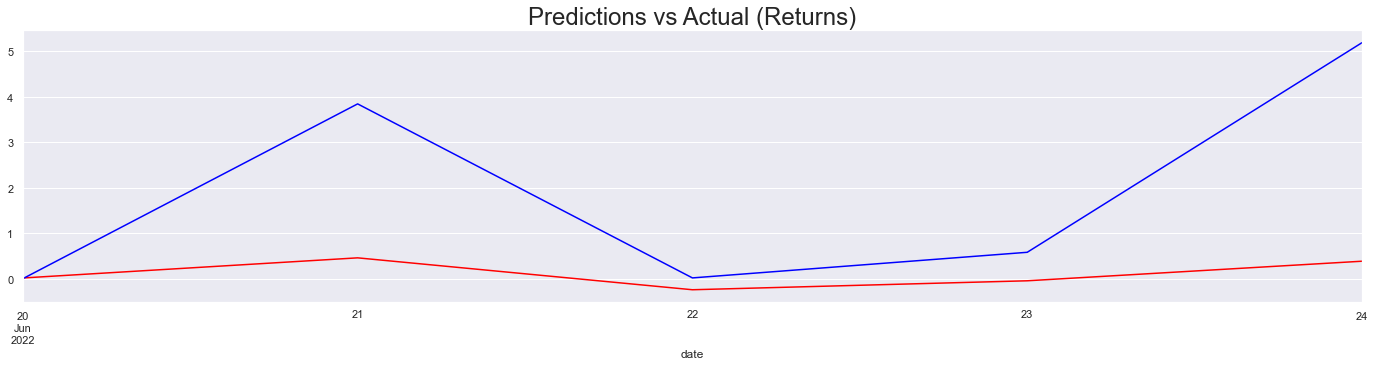

AR 7.016624692766726


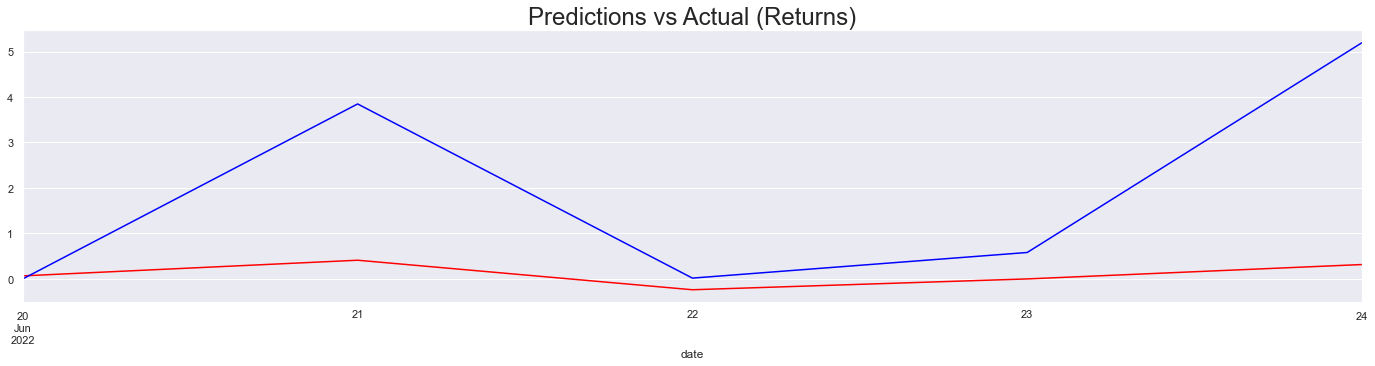

MA 7.204637696202411


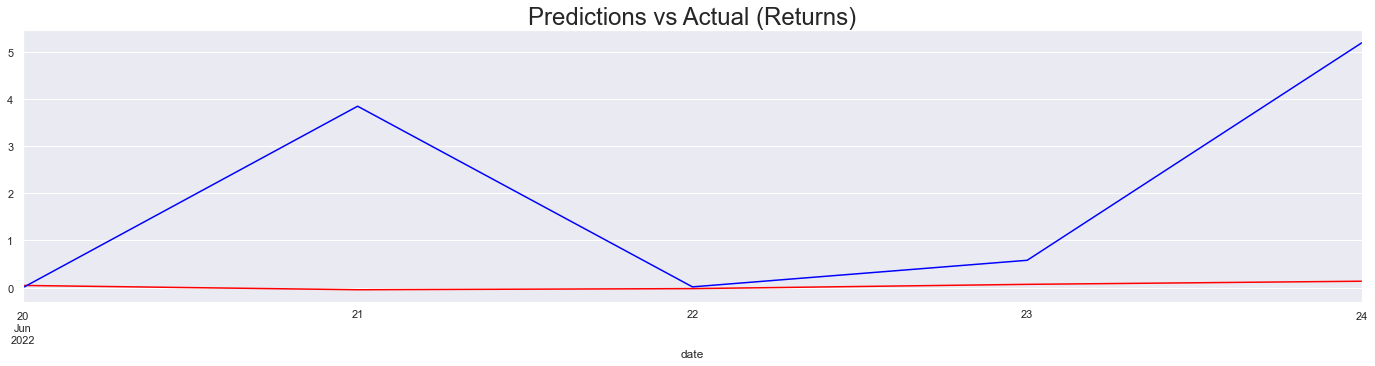

ARMA 8.197000108423362


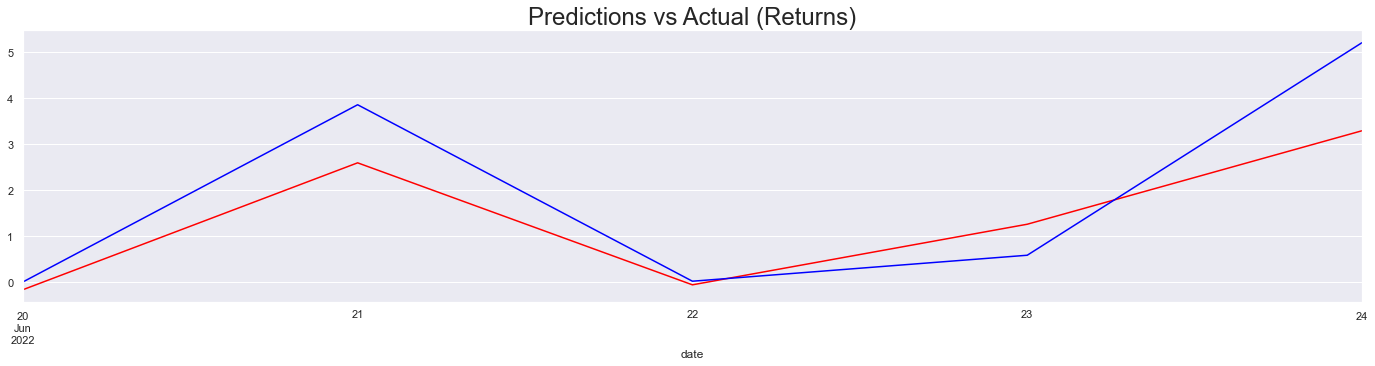

ARMAX 1.1462391250403452


1.3786292239132731

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 
#AR
model_ret_ar_9 = ARIMA(df_train.ret_goog, order = (9,0,0))
results_ret_ar_9 = model_ret_ar_9.fit()
df_pred_ar_9 = results_ret_ar_9.predict(start =start_date, end = end_date)

df_pred_ar_9[start_date:end_date].plot(figsize = (24,5), color ="red")
df_test.ret_goog[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()


model_ret_ar_9 = mean_squared_error(df_pred_ar_9[start_date:end_date],df_test.ret_goog[start_date:end_date])
print("AR",model_ret_ar_9)

#MA
model_ret_ma_9 = ARIMA(df_train.ret_goog, order = (0,0,9))
results_ret_ma_9 = model_ret_ma_9.fit()
df_pred_ma_9 = results_ret_ma_9.predict(start =start_date, end = end_date)

df_pred_ma_9[start_date:end_date].plot(figsize = (24,5), color ="red")
df_test.ret_goog[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ma_9 = mean_squared_error(df_pred_ma_9[start_date:end_date],df_test.ret_goog[start_date:end_date])
print("MA",model_ret_ma_9)

#ARMA
model_ret_ar_3_ma_3 = ARIMA(df_train.ret_goog, order = (3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
df_pred_ar_3_ma_3 = results_ret_ar_3_ma_3.predict(start =start_date, end = end_date)

df_pred_ar_3_ma_3[start_date:end_date].plot(figsize = (24,5), color ="red")
df_test.ret_goog[start_date:end_date].plot(color ='blue')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_ar_3_ma_3 = mean_squared_error(df_pred_ar_3_ma_3[start_date:end_date],df_test.ret_goog[start_date:end_date])
print("ARMA",model_ret_ar_3_ma_3)

#ARMAX
model_ret_armax = ARIMA(df_train.ret_goog[1:], exog = df_train[["ret_spx"]][1:], order = (9,0,9))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test["ret_spx"][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (24,5), color = "red")
df_test.ret_goog[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

model_ret_armax = mean_squared_error(df_pred_armax[start_date:end_date],df_test.ret_goog[start_date:end_date])
print("ARMAX", model_ret_armax)

df_pred_armax.mean()

# Final results

In [ ]:
mean_returns = pd.DataFrame({
    'aapl': [1.5],
    'nikkei': [0.34],
    'ftse': [0.61],
    'spx': [1.11],
    'amzn': [2.11],
    'amd': [1.32],
    'goog': [1.37],
})


In [ ]:
total_capital = 100000

In [ ]:
weights = mean_returns / mean_returns.sum(axis=1).values[0]

In [ ]:
mean_returns

,aapl,nikkei,ftse,spx,amzn,amd,goog
0,1.5,0.34,0.61,1.11,2.11,1.32,1.37


In [ ]:
weights

,aapl,nikkei,ftse,spx,amzn,amd,goog
0,0.179426,0.04067,0.072967,0.132775,0.252392,0.157895,0.163876


In [ ]:
capital_allocation = weights * total_capital
capital_allocation

,aapl,nikkei,ftse,spx,amzn,amd,goog
0,17942.583732,4066.985646,7296.650718,13277.511962,25239.23445,15789.473684,16387.559809


In [ ]:
expected_portfolio_return = (capital_allocation * mean_returns).sum()
print(f"Expected Portfolio Return: {expected_portfolio_return}")

Expected Portfolio Return: aapl      26913.875598
nikkei     1382.775120
ftse       4450.956938
spx       14738.038278
amzn      53254.784689
amd       20842.105263
goog      22450.956938
dtype: float64


In [ ]:
df_comp.describe()

symbol,nikkei,ftse,spx,aapl,amd,amzn,goog,gs,ibm,jpm,...,nflx,nvda,tsla,ret_spx,ret_aapl,ret_nikkei,ret_ftse,ret_amd,ret_amzn,ret_goog
count,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,...,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000
mean,25060.734567,7118.813462,3524.785787,103.290170,64.625196,118.606343,88.344440,254.304711,110.716110,113.015817,...,385.003654,135.069790,138.797378,0.031975,0.091549,0.022391,0.004323,0.155334,0.056554,0.057815
std,3452.244603,549.943006,672.592418,48.982577,36.812094,34.107928,30.638193,73.066504,12.314471,22.425980,...,114.159873,94.103503,114.245961,1.107132,1.694413,1.002462,0.907121,2.932070,1.864183,1.649831
min,16552.830078,4993.899902,2237.399902,34.075405,9.530000,60.479500,48.811001,122.197914,74.493599,69.640205,...,166.369995,31.521744,11.931333,-11.984055,-12.864715,-6.080833,-10.873819,-15.445372,-14.049438,-11.100818
25%,22162.240234,6960.099854,2874.689941,50.304880,29.042500,89.644627,59.275625,187.928635,102.649530,93.066528,...,305.437500,58.326387,21.868334,-0.175039,-0.336543,-0.257609,-0.188024,-0.798901,-0.451006,-0.330383
50%,23999.359375,7243.800049,3471.264893,114.767319,69.400002,106.657753,80.908501,223.685738,108.723503,109.181438,...,360.460007,125.898056,136.725998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,27941.287598,7502.200195,4134.949951,146.801086,91.652502,155.811005,114.895500,322.136703,120.112858,133.915874,...,486.882492,187.874115,235.950001,0.357466,0.669832,0.365496,0.297819,1.127874,0.639497,0.585801
max,33753.328125,8014.299805,4796.560059,195.677261,161.910004,186.570496,150.709000,395.365997,142.149780,159.780838,...,691.690002,474.836853,409.970001,9.382774,11.980838,8.038101,9.053047,19.948053,13.535902,10.448541


### Actual returns

In [ ]:
actual_returns = df_comp.drop(columns=[ 'aapl','nikkei', 'ftse', 'spx', 'amd', 'amzn', 'goog', 'gs', 'ibm', 'jpm', 'msft', 'nflx', 'nvda', 'tsla', 'meta'])

In [ ]:
import pandas as pd

start_date = '2022-06-20'
end_date = '2022-06-24'

selected_data = actual_returns.loc[start_date:end_date]

selected_data

symbol,ret_spx,ret_aapl,ret_nikkei,ret_ftse,ret_amd,ret_amzn,ret_goog
date,,,,,,,
2022-06-20,0.000000,0.000000,-0.738664,1.503642,0.000000,0.000000,0.000000
2022-06-21,2.447724,3.276059,1.843490,0.425458,2.721590,2.315947,3.846919
2022-06-22,-0.130157,-0.382705,-0.368660,-0.879461,-0.047739,0.248433,0.016960
2022-06-23,0.953222,2.157370,0.082981,-0.969082,-1.576119,3.203309,0.580632
2022-06-24,3.056329,2.451741,1.225470,2.682142,5.641152,3.575237,5.194592


In [ ]:
selected_data.mean()

symbol
ret_spx       1.265424
ret_aapl      1.500493
ret_nikkei    0.408923
ret_ftse      0.552540
ret_amd       1.347777
ret_amzn      1.868585
ret_goog      1.927820
dtype: float64

In [ ]:
mean_returns_actual = pd.DataFrame({
    'aapl': [1.5],
    'nikkei': [0.4],
    'ftse': [0.55],
    'spx': [1.26],
    'amzn': [1.88],
    'amd': [1.34],
    'goog': [1.92],
})


In [ ]:
total_capital_actual = 100000

In [ ]:
weights_actual = mean_returns_actual / mean_returns_actual.sum(axis=1).values[0]
weights_actual

,aapl,nikkei,ftse,spx,amzn,amd,goog
0,0.169492,0.045198,0.062147,0.142373,0.212429,0.151412,0.216949


In [ ]:
capital_allocation_actual = weights_actual * total_capital_actual
capital_allocation_actual

,aapl,nikkei,ftse,spx,amzn,amd,goog
0,16949.152542,4519.774011,6214.689266,14237.288136,21242.937853,15141.242938,21694.915254


In [ ]:
actual_portfolio_return = (capital_allocation_actual * mean_returns_actual).sum()
print(f"Actual Portfolio Return: {actual_portfolio_return}")

Actual Portfolio Return: aapl      25423.728814
nikkei     1807.909605
ftse       3418.079096
spx       17938.983051
amzn      39936.723164
amd       20289.265537
goog      41654.237288
dtype: float64


In [ ]:
expected_portfolio_return.sum()


144033.4928229665

In [ ]:
actual_portfolio_return.sum()

150468.92655367233

In [ ]:
comparison = pd.DataFrame({
    'predicted': expected_portfolio_return,
    'actual': actual_portfolio_return
})
comparison['difference'] = comparison['predicted'] - comparison['actual']
print(comparison)

           predicted        actual    difference
aapl    26913.875598  25423.728814   1490.146785
nikkei   1382.775120   1807.909605   -425.134485
ftse     4450.956938   3418.079096   1032.877842
spx     14738.038278  17938.983051  -3200.944773
amzn    53254.784689  39936.723164  13318.061525
amd     20842.105263  20289.265537    552.839726
goog    22450.956938  41654.237288 -19203.280350
